# Objective

Develop a machine learning model to predict customer churn and provide insights into the reasons for churn using feature importance analysis.

# Data Understanding

| No. | Column Name                | Description                                                                 |
|-----|----------------------------|-----------------------------------------------------------------------------|
| 1   | user_id                    | Customer account number.                                                    |
| 2   | attrition_flag             | Customer status (Existing and Attrited).                                    |
| 3   | customer_age               | Age of the customer.                                                        |
| 4   | gender                     | Gender of customer (M for male and F for female).                           |
| 5   | dependent_count            | Number of dependents of customers.                                          |
| 6   | education_level            | Customer education level (Uneducated, High School, Graduate, College, Post-Graduate, Doctorate, Unknown). |
| 7   | marital_status             | Customer's marital status (Single, Married, Divorced, and Unknown).         |
| 8   | income_category            | Customer income interval category (Less than \$40K, \$40K-\$60K, \$60K-\$80K, \$80K-\$120K, \$120K+, Unknown). |
| 9   | card_category              | Type of card used (Blue, Silver, Gold, and Platinum).                      |
| 10  | months_on_book             | Period of being a customer (in months).                                     |
| 11  | total_relationship_count   | The number of products used by customers in the bank.                       |
| 12  | months_inactive_12_mon     | Period of inactivity for the last 12 months.                                |
| 13  | contacts_count_12_mon      | The number of interactions between the bank and the customer in the last 12 months. |
| 14  | credit_limit               | Credit card transaction nominal limit in one period.                        |
| 15  | total_revolving_bal        | Total funds used in one period.                                             |
| 16  | avg_open_to_buy            | The difference between the credit limit set for the cardholder's account and the current balance. |
| 17  | total_amt_chng_q4_q1       | Increase in customer transaction nominal between quarter 4 and quarter 1.  |
| 18  | total_trans_amt            | Total nominal transaction in the last 12 months.                           |
| 19  | total_trans_ct             | The number of transactions in the last 12 months.                          |
| 20  | total_ct_chng_q4_q1        | The number of customer transactions increased between quarter 4 and quarter 1. |
| 21  | avg_utilization_ratio      | Percentage of credit card usage.                                           |


# Importing Library

In [1]:
!pip install scipy==1.11.4
!pip install dalex

In [2]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import dalex as dx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import argmax
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency, ttest_ind, pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, average_precision_score, classification_report, roc_curve, confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load the Dataset

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/bank_churn_dataset/bank_churn_data.csv')

In [4]:
# Display all rows
pd.set_option('display.max_columns', None)

df.head()

,user_id,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


From the dataset description and the entries in the dataset, we can see that these features are correlated:

`credit_limit` = `total_revolving_bal` + `avg_open_to_buy`

`avg_utilization_ratio` = `total_revolving_bal` / `credit_limit`

This will create a multicollinearity issue, which we will verify in the "Correlation Matrix and VIF" section.

In [5]:
# Reset the display
pd.reset_option('display.max_columns')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

Based on the dataset above, there are no missing values.

# Data Preprocessing

## Handling Duplicate Data

In [7]:
# Check duplicate data
df.duplicated().sum().sum()

0

There is no duplicate data in the dataset.

## Handling Missing Values

In [8]:
df.isna().sum().sum()

0

There are no missing values in the dataset.

## Converting Data Type

In [9]:
df["user_id"] = df["user_id"].astype('object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10127 non-null  object 
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

Now, the dataset has consistent and correct data types.

## Handling Error Data

Pandas DataFrame can automatically convert a numeric column to an object type if it contains even a single non-numeric value. Therefore, if a column retains its numeric type, its data distribution can be directly analyzed using `df.describe()`.

For categorical columns, data errors should be reviewed per column to ensure consistency and accuracy.

In [11]:
df.describe()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


For the numeric variables above, based on the output of `.describe()`, there are no unusual values such as negative values or infinities (inf).

In [12]:
df["user_id"].value_counts().sort_index()

,count
user_id,
708082083,1
708083283,1
708084558,1
708085458,1
708086958,1
...,...
828288333,1
828291858,1
828294933,1


In [13]:
df["attrition_flag"].value_counts().sort_index()

,count
attrition_flag,
Attrited Customer,1627
Existing Customer,8500


In [14]:
df["gender"].value_counts().sort_index()

,count
gender,
F,5358
M,4769


In [15]:
df["education_level"].value_counts().sort_index()

,count
education_level,
College,1013
Doctorate,451
Graduate,3128
High School,2013
Post-Graduate,516
Uneducated,1487
Unknown,1519


In [16]:
df["marital_status"].value_counts().sort_index()

,count
marital_status,
Divorced,748
Married,4687
Single,3943
Unknown,749


In [17]:
df["income_category"].value_counts().sort_index()

,count
income_category,
$120K +,727
$40K - $60K,1790
$60K - $80K,1402
$80K - $120K,1535
Less than $40K,3561
Unknown,1112


In [18]:
df["card_category"].value_counts().sort_index()

,count
card_category,
Blue,9436
Gold,116
Platinum,20
Silver,555


It seems there are no errors in the categorical columns above.

## Dropping Unused Column

These columns are not important for building machine learning models because they are merely identifiers.

In [19]:
df = df.drop(columns=['user_id'])

# Splitting the Dataset

In [20]:
X = df.drop(['attrition_flag'],axis = 1)
y = df['attrition_flag']

# The dataset is imbalanced (8500:1627 ~ 5.2:1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y) # maintain the proportion of classes in both sets
X_train.shape, X_test.shape

((8101, 19), (2026, 19))

In [21]:
# Concat the X_train and y_train
train = pd.concat([X_train, y_train], axis=1)

In [22]:
# Concat the X_test and y_test
test = pd.concat([X_test, y_test], axis=1)

# Creating a New Feature

New Feature: "**Customer Engagement Score**" OR "**CES**"

This feature could combine multiple factors that reflect both customer engagement and financial behavior, which may help to predict attrition risk.

In [23]:
# train_ces = train.copy()
# test_ces = test.copy()

In [24]:
# # Create a MinMaxScaler instance for normalization
# scaler = MinMaxScaler()

# columns_to_normalize = [
#     'total_relationship_count',
#     'contacts_count_12_mon',
#     'total_trans_amt',
#     'credit_limit',
#     'avg_utilization_ratio'
# ]

# # Apply Min-Max scaling (normalize the selected columns)
# train_ces[columns_to_normalize] = scaler.fit_transform(train_ces[columns_to_normalize])
# test_ces[columns_to_normalize] = scaler.transform(test_ces[columns_to_normalize])

In [25]:
# # Check the minimum value
# train_ces['credit_limit'].min()

In [26]:
# # Replace 0 with a small value to avoid dividing by zero
# train_ces['credit_limit'] = train_ces['credit_limit'].replace(0, 1e-6)
# test_ces['credit_limit'] = test_ces['credit_limit'].replace(0, 1e-6)

In [27]:
# # Check again the minimum value
# train_ces['credit_limit'].min()

In [28]:
# train_ces['CES'] = (train_ces['total_relationship_count'] * 0.3) + \
#                    (train_ces['contacts_count_12_mon'] * 0.3) + \
#                    (train_ces['total_trans_amt'] / train_ces['credit_limit'] * 0.2) + \
#                    (train_ces['avg_utilization_ratio'] * 0.2)

In [29]:
# test_ces['CES'] = (test_ces['total_relationship_count'] * 0.3) + \
#                    (test_ces['contacts_count_12_mon'] * 0.3) + \
#                    (test_ces['total_trans_amt'] / test_ces['credit_limit'] * 0.2) + \
#                    (test_ces['avg_utilization_ratio'] * 0.2)

In [30]:
# # assign back to the original dataframe
# train['CES'] = train_ces['CES'].copy()
# test['CES'] = test_ces['CES'].copy()

In [31]:
# # checking the index and the entry
# train_ces.head(2)

In [32]:
# # checking the index and the entry
# train.head(2)

Explanation
- `total_relationship_count` (0.3): Reflects how many bank products the customer is using. The more products they use, the more engaged they are with the bank, which can reduce the likelihood of attrition.
- `contacts_count_12_mon` (0.3): Number of interactions the customer had with the bank. Higher interaction could suggest the customer is active and engaged with the bank.
- `total_trans_amt` / `credit_limit` (0.2): This measures how much of their credit limit the customer is using. A higher ratio may indicate high utilization, potentially showing that the customer relies on their credit and is actively using it.
- `avg_utilization_ratio` (0.2): This gives a percentage of how much of the credit limit the customer uses on average, giving insight into their financial behavior and engagement with the bank.

Why This Feature Helps:
- Engagement + Financial Behavior: Combining product usage, customer interaction, and credit card utilization can give a better understanding of how engaged and financially reliant a customer is.
- Predicting Attrition: Higher engagement scores may indicate that customers are more likely to stay, while lower scores could correlate with higher attrition rates.

**Note**
- I have conducted experiments using the new feature `CES` in the Experiment section. The results indicate that it improves the performance metrics for the Decision Tree but decreases them for the other tree-based models (Random Forest, LightGBM, XGBoost). Therefore, I have decided **not** to use this new feature.

# Exploratory Data Analysis

## Handling Outliers

In [33]:
train.describe()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000
mean,46.327120,2.350574,35.938279,3.820886,2.335514,2.449944,8636.210838,1162.422540,7473.788298,0.759994,4393.027034,64.752253,0.711916,0.274138
std,7.985768,1.296832,7.957442,1.547005,1.002347,1.103919,9107.980541,814.680244,9107.090992,0.219483,3396.981611,23.486066,0.238334,0.274709
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,530.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,32.000000,3.000000,2.000000,2.000000,2553.000000,357.000000,1335.000000,0.631000,2151.000000,45.000000,0.583000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1279.000000,3451.000000,0.738000,3890.000000,67.000000,0.700000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.000000,1781.000000,9885.000000,0.860000,4730.000000,80.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.571000,0.999000


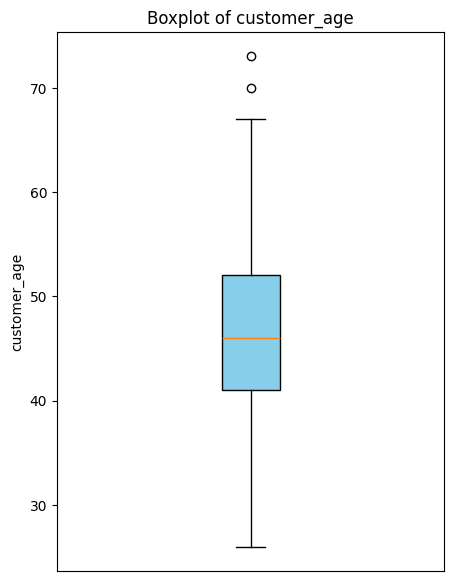

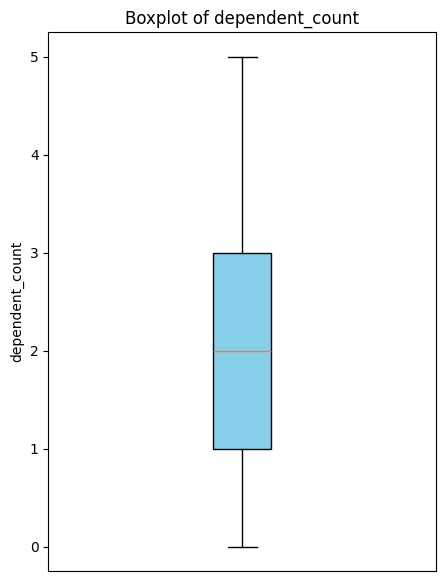

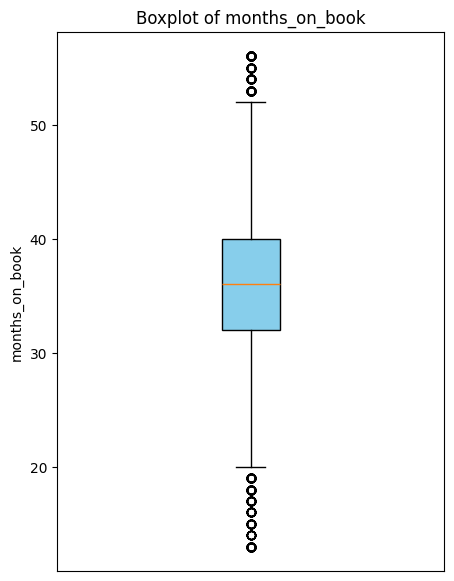

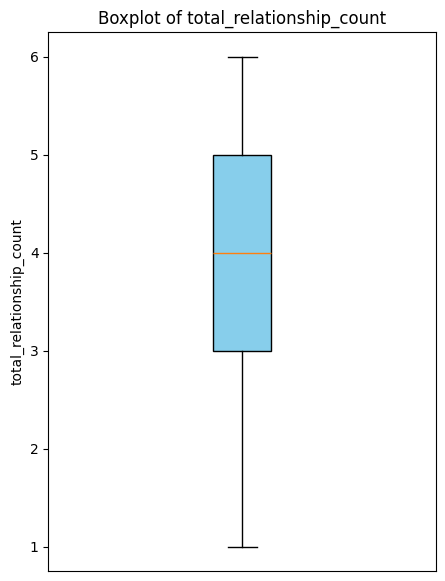

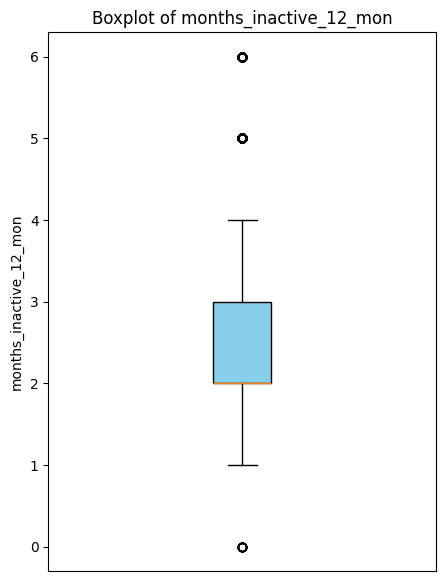

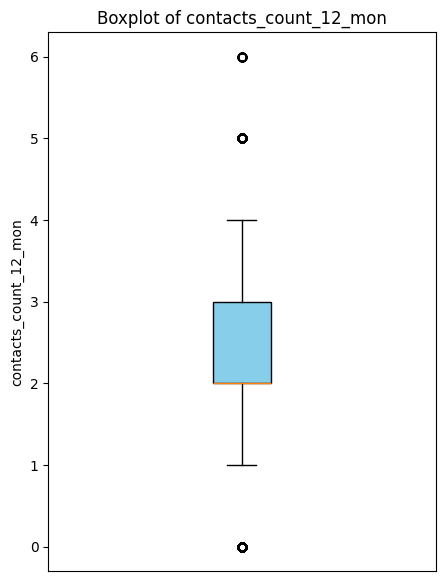

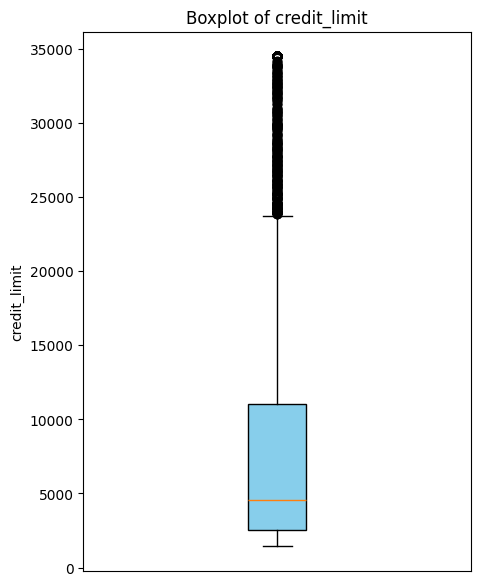

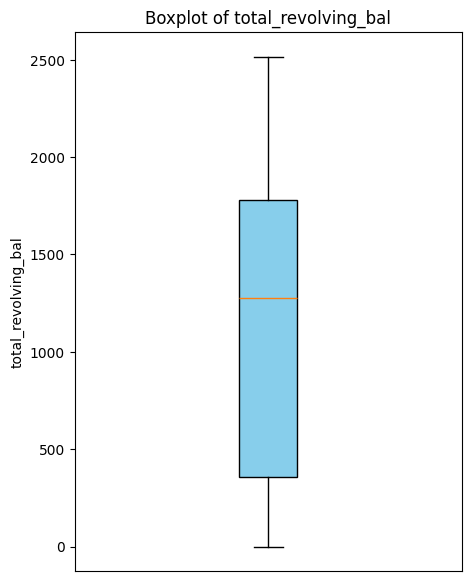

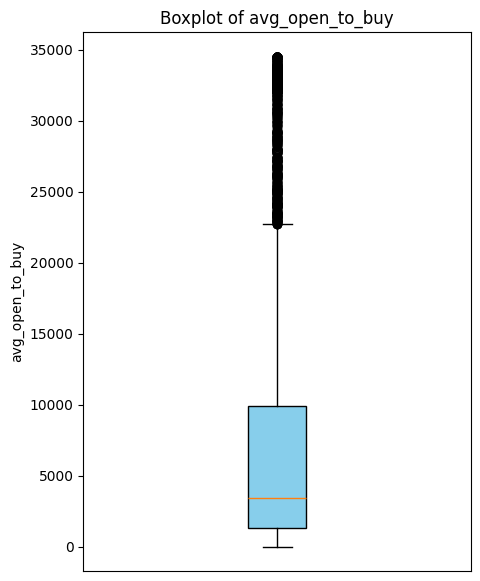

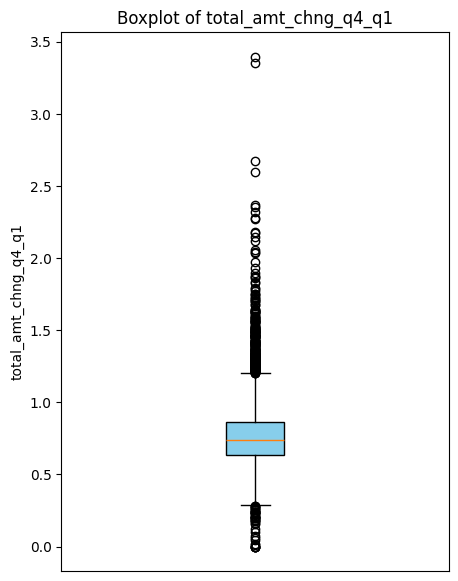

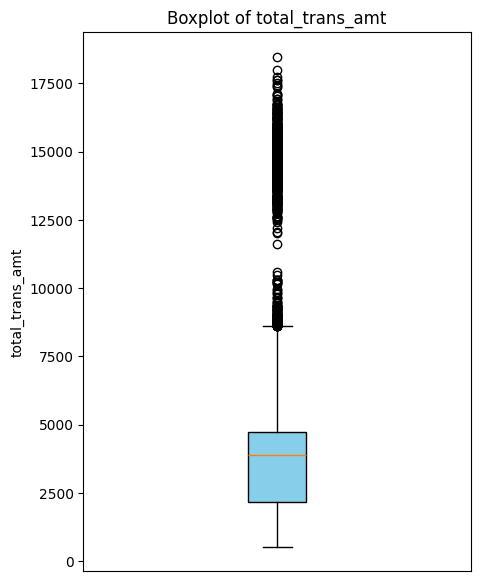

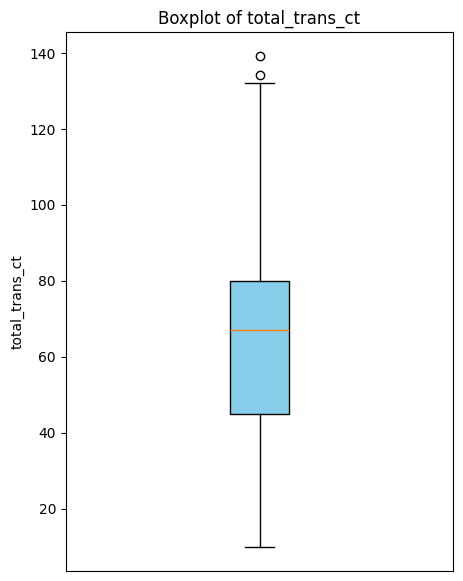

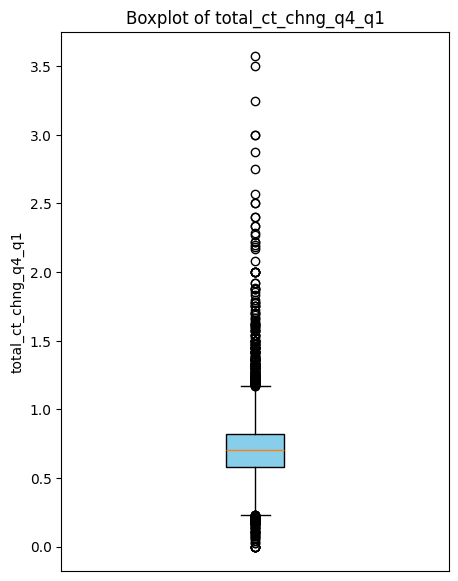

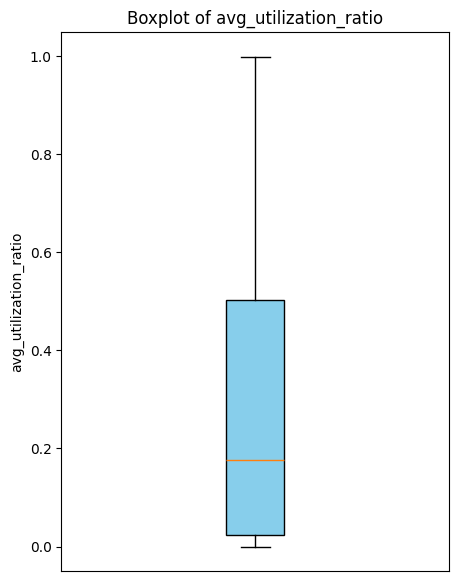

In [34]:
# Get numerical columns
numerical_features = train.select_dtypes(include=['number']).columns

# Create individual boxplots
for feature in numerical_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel(feature)
    plt.xlabel('')
    plt.xticks([])
    plt.show()

In [35]:
train[train['total_amt_chng_q4_q1'] > 3]

,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,attrition_flag
8,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,Existing Customer
12,56,M,1,College,Single,$80K - $120K,Blue,36,3,6,0,11751.0,0,11751.0,3.397,1539,17,3.250,0.000,Existing Customer


From the table and the boxplot, there are no extreme outliers. The data appears valid and natural.

## Handling Skewness

Skewness Interpretation
- 0 to ±0.5 → Nearly symmetric (No transformation needed)
- ±0.5 to ±1.0 → Moderately skewed (Mild transformation)
- \>±1.0 → Strongly skewed (Stronger transformation required)

In [36]:
train.skew(numeric_only = True)

,0
customer_age,-0.027948
dependent_count,-0.020269
months_on_book,-0.098070
total_relationship_count,-0.162101
months_inactive_12_mon,0.612706
contacts_count_12_mon,0.014772
credit_limit,1.671626
total_revolving_bal,-0.147884
avg_open_to_buy,1.666628
total_amt_chng_q4_q1,1.752969


The columns `months_inactive_12_mon`, `credit_limit`, `avg_utilization_ratio`, `total_amt_chng_q4_q1`, and `total_ct_chng_q4_q1` exhibit moderate to strong skewness, so I will apply a transformation to reduce their skewness.

In [37]:
# # Skewness Transformations
# train['months_inactive_12_mon'] = np.sqrt(train['months_inactive_12_mon'])
# train['credit_limit'] = np.log1p(train['credit_limit']) # adding 1 to avoid issues with zero values
# train['avg_utilization_ratio'] = np.sqrt(train['avg_utilization_ratio'])

In [38]:
# test['months_inactive_12_mon'] = np.sqrt(test['months_inactive_12_mon'])
# test['credit_limit'] = np.log1p(test['credit_limit'])
# test['avg_utilization_ratio'] = np.sqrt(test['avg_utilization_ratio'])

In [39]:
# # Ensure the data is strictly positive
# pt_1 = PowerTransformer(method='yeo-johnson')

# # Apply transformation (convert to 2D array with .values.reshape(-1, 1))
# train['total_amt_chng_q4_q1'] = pt_1.fit_transform(train['total_amt_chng_q4_q1'].values.reshape(-1, 1))
# test['total_amt_chng_q4_q1'] = pt_1.transform(test['total_amt_chng_q4_q1'].values.reshape(-1, 1))

# pt_2 = PowerTransformer(method='yeo-johnson')

# train['total_ct_chng_q4_q1'] = pt_2.fit_transform(train['total_ct_chng_q4_q1'].values.reshape(-1, 1))
# test['total_ct_chng_q4_q1'] = pt_2.transform(test['total_ct_chng_q4_q1'].values.reshape(-1, 1))

In [40]:
# train.skew(numeric_only = True)

While skewness transformations can improve the performance of some machine learning models, they are generally less critical for tree-based models like DecisionTree, RandomForest, LightGBM, and XGBoost. Let's conduct an experiment to validate whether these transformations enhance the specific model's performance.

**Note**

- I have tested the Skewness Transformation in the Experiment section, and it only slightly improved the performance metrics for the Random Forest and LightGBM models. However, it had no noticeable effect on the Decision Tree and XGBoost models. Since the overall impact of the Skewness Transformation is not significant across the models, I have decided **not** to apply it.

- Moreover, applying the transformation would make it less intuitive to interpret the relationship between input features and output predictions, as the real-world influence of the features would need to be analyzed with the transformation taken into account.

## Target Distribution

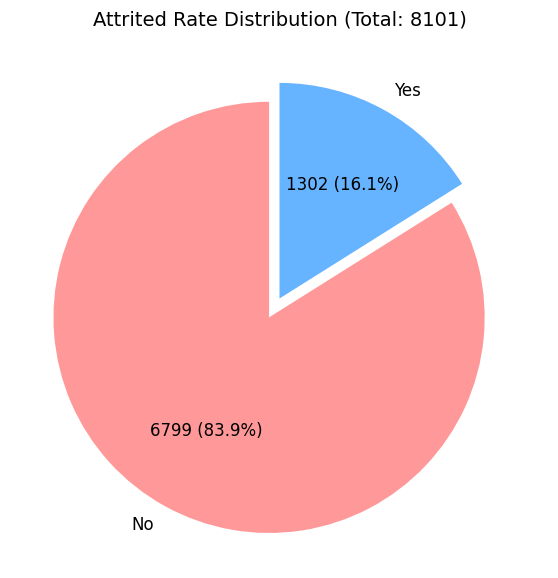

In [41]:
# Calculate the frequency of each class
target_counts = train['attrition_flag'].value_counts()

# Define colors to improve contrast
colors = ['#ff9999', '#66b3ff']

# Exploding the largest segment for emphasis
explode = [0.1 if i == target_counts.idxmax() else 0 for i in target_counts.index]

# Map the target values (1, 0) to their respective labels
label_map = {'Existing Customer': 'No', 'Attrited Customer': 'Yes'}

# Function to format the autopct with both number and percentage
def func(pct, allvalues):
    absolute = round(pct / 100.*sum(allvalues))
    return f"{absolute} ({pct:.1f}%)"

# Plot the pie chart without outline (no edgecolor)
plt.figure(figsize=(7, 7))
plt.pie(target_counts, labels=[label_map[i] for i in target_counts.index], autopct=lambda pct: func(pct, target_counts), startangle=90, colors=colors, explode=explode, wedgeprops={'edgecolor': 'none'}, textprops={'fontsize': 12})
plt.title(f'Attrited Rate Distribution (Total: {target_counts.sum()})', fontsize=14, pad=0)
plt.show()


The target distribution is imbalanced, with 83.9% existing customers and 16.1% attrited customers (5.2:1). However, based on the general rule of thumb, since the imbalance is not severe (e.g., greater than 9:1), we will not apply oversampling in this case.

## Question 1

Because these exploratory data analysis questions will be used to analyze the model later, I will use the **train** set instead of the full dataset (df).

In [42]:
train_eda = train.copy()

**a. Seperti apa distribusi usia para nasabah? Usia manakah yang cenderung memiliki kemungkinan churn terbesar?**

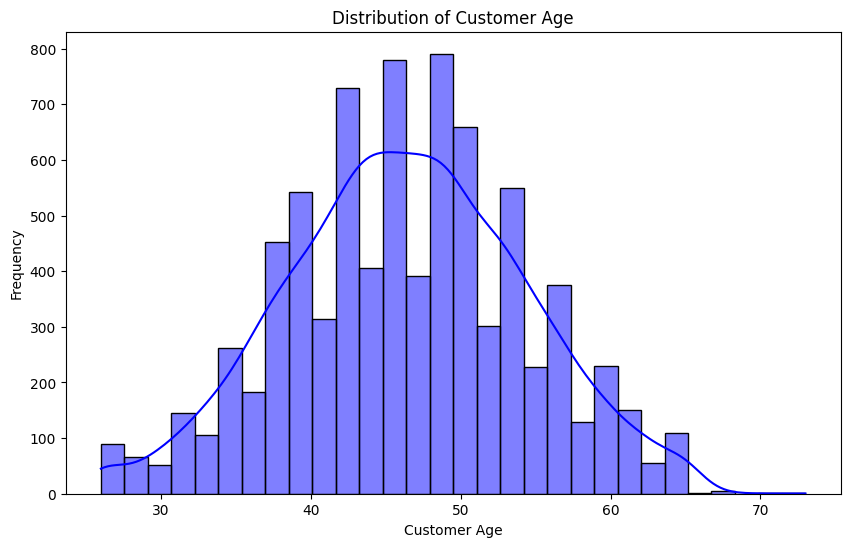

In [43]:
# Plot the distribution of customer age
plt.figure(figsize=(10, 6))
sns.histplot(train_eda['customer_age'], bins=30, kde=True, color='blue')
plt.title('Distribution of Customer Age')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.show()

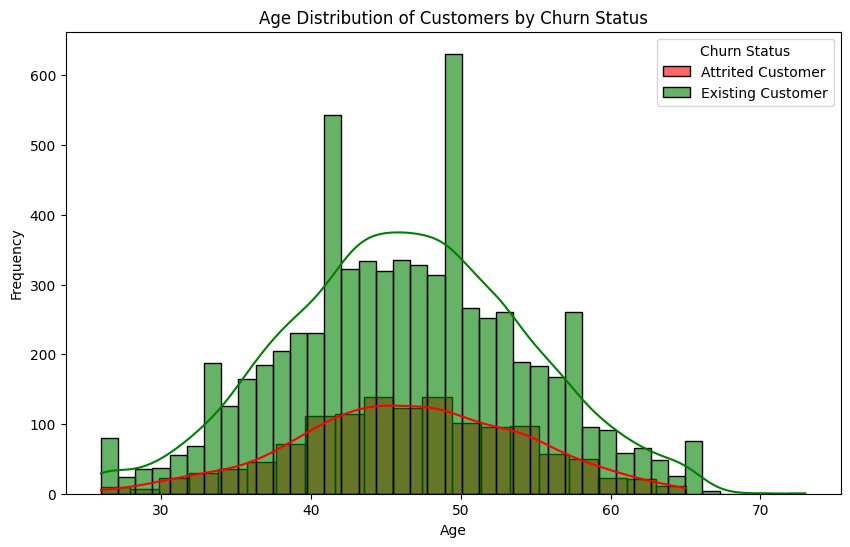

In [44]:
plt.figure(figsize=(10, 6))

# Churned customers (Attrited Customer)
sns.histplot(train_eda[train_eda['attrition_flag'] == 'Attrited Customer']['customer_age'], kde=True, color='red', label='Attrited Customer', alpha=0.6)

# Non-churned customers (Existing Customer)
sns.histplot(train_eda[train_eda['attrition_flag'] == 'Existing Customer']['customer_age'], kde=True, color='green', label='Existing Customer', alpha=0.6)

# Adding title and labels
plt.title('Age Distribution of Customers by Churn Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(title="Churn Status")
plt.show()

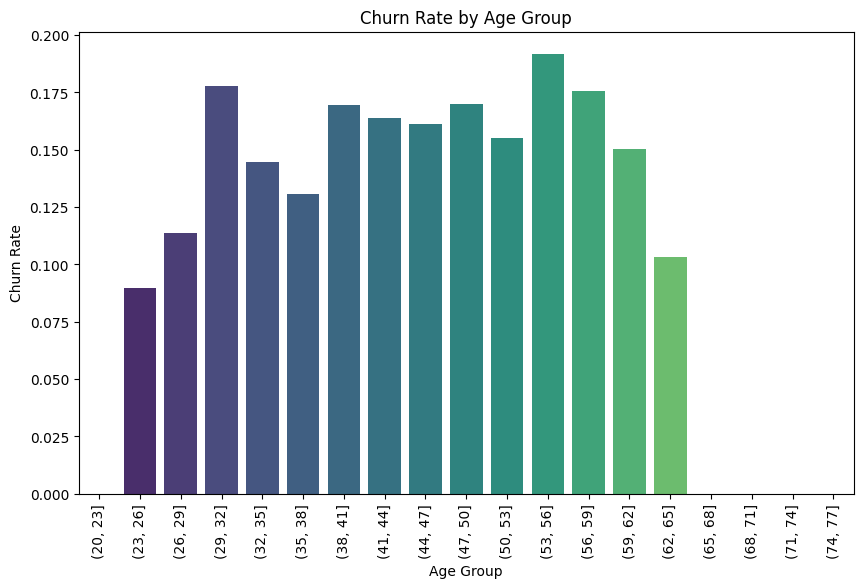

In [45]:
# Calculate churn rate by age group
train_eda['age_group'] = pd.cut(train_eda['customer_age'], bins=range(20, 80, 3))
churn_by_age = train_eda.groupby('age_group')['attrition_flag'].apply(lambda x: (x == 'Attrited Customer').mean()).reset_index()

# Plot churn rate by age group
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='attrition_flag', data=churn_by_age, palette='viridis')
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=90)
plt.show()

The age distribution of customers, as shown in the plot (**Distribution of Customer Age**), follows a normal-like distribution, with a clear peak **around the 40-50 years** age range.
- The highest frequency of customers is concentrated between 40 and 50 years old, where the number of customers is the largest, indicating that the majority of customers are in their middle age.
- There is a gradual decline in the number of customers as the age increases, with the distribution tapering off in the 60-70 years range.
- Fewer customers are present in the younger age groups (20-30 years) and the older age groups (60-70 years), suggesting that the bank has more middle-aged clients and fewer younger or older clients.

Based on the **Churn Rate by Age Group** plot, **the age groups with the highest churn rates are 29–32 years and 53–59 years**. These two age groups exhibit the largest proportion of churned customers relative to the total number of customers within those groups.

The 29–32 and 53–59 age groups show a notable spike in churn rates, suggesting that customers in these age ranges are more likely to churn compared to other age groups.

**b. Apakah terdapat korelasi antara tingkat pendidikan dan income category? Bagaimana korelasi dari kedua prediktor tersebut terhadap churn?**

In [46]:
# Since 'education_level' and 'income_category' are categorical, we will use chi-square test to check correlation
edu_income_crosstab = pd.crosstab(train_eda['education_level'], train_eda['income_category'])
chi2, p, _, _ = chi2_contingency(edu_income_crosstab)
print(f"Chi-Square Test for Education and Income: p-value = {p:.4f}")

Chi-Square Test for Education and Income: p-value = 0.0736


In [47]:
edu_churn_crosstab = pd.crosstab(train_eda['education_level'], train_eda['attrition_flag'])
income_churn_crosstab = pd.crosstab(train_eda['income_category'], train_eda['attrition_flag'])

chi2_edu, p_edu, _, _ = chi2_contingency(edu_churn_crosstab)
chi2_income, p_income, _, _ = chi2_contingency(income_churn_crosstab)

print(f"Chi-Square Test for Education and Churn: p-value = {p_edu:.4f}")
print(f"Chi-Square Test for Income and Churn: p-value = {p_income:.4f}")

Chi-Square Test for Education and Churn: p-value = 0.0880
Chi-Square Test for Income and Churn: p-value = 0.0657


The Chi-Square test is used to determine whether there is a significant relationship between two categorical variables. The p-value helps us decide if the relationship is statistically significant. Typically, a p-value below 0.05 indicates a strong relationship, while a higher value suggests weak or no significant association.

1. Chi-Square Test for Education and Income (p-value = 0.0736)
  - Since 0.0736 > 0.05, we fail to reject the null hypothesis.
  - This means there is **no strong statistical evidence** of a relationship between education level and income category, though there may be a weak trend.
2. Chi-Square Test for Education and Churn (p-value = 0.0880)
  - Since 0.0880 > 0.05, we fail to reject the null hypothesis.
  - This suggests that **education level does not have a significant impact on churn**, though there may be a slight trend.
3. Chi-Square Test for Income and Churn (p-value = 0.0657)
  - Since 0.0657 > 0.05, we fail to reject the null hypothesis.
  - This means **income category is not strongly associated with churn**, though the p-value is close to 0.05, indicating a weak potential relationship.

There is no strong correlation between education level and income category. Additionally, neither education level nor income category has a significant effect on churn probability.

**c. Apakah terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn?**

In [48]:
# I use a t-test because we are comparing the means of two groups (male vs. female churn rates).

# Convert attrition_flag to numerical format
train_eda['attrition_flag'] = train_eda['attrition_flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

churn_male = train_eda[train_eda['gender'] == 'M']['attrition_flag']
churn_female = train_eda[train_eda['gender'] == 'F']['attrition_flag']

t_stat, p_val = ttest_ind(churn_male, churn_female, equal_var=False)
print(f"T-Test for Gender and Churn: p-value = {p_val:.4f}")

T-Test for Gender and Churn: p-value = 0.0003


In [49]:
def prop_agg(df, y, x):
  temp_df = df.groupby([y,x], as_index = False).size()
  temp_df['prop'] = temp_df['size'] / temp_df.groupby(y)['size'].transform('sum')
  return temp_df

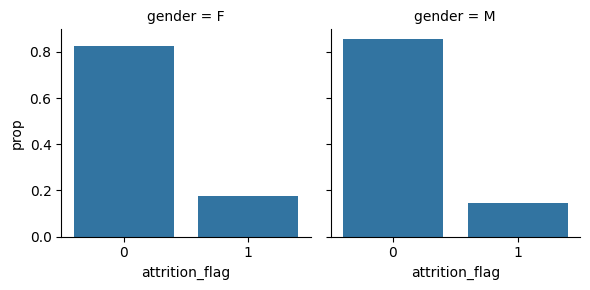

In [50]:
g = sns.FacetGrid(
    data = prop_agg(train_eda, "gender", "attrition_flag"),
    col = "gender"
)
g.map(sns.barplot, "attrition_flag", "prop");

The t-test p-value = 0.0003, which is far below the significance threshold of 0.05. This means that there is a statistically significant difference in churn rates between male and female customers.

Since the p-value is very low, we reject the null hypothesis, meaning **gender does influence churn likelihood**.

The plot suggests that females may have a slightly higher churn rate than males, though both genders experience churn.
This could indicate that female customers might have different banking behaviors or customer service needs compared to male customers.

**d. Apakah semakin lama customer menjadi nasabah maka semakin kecil kemungkinan nasabah tersebut untuk churn?**

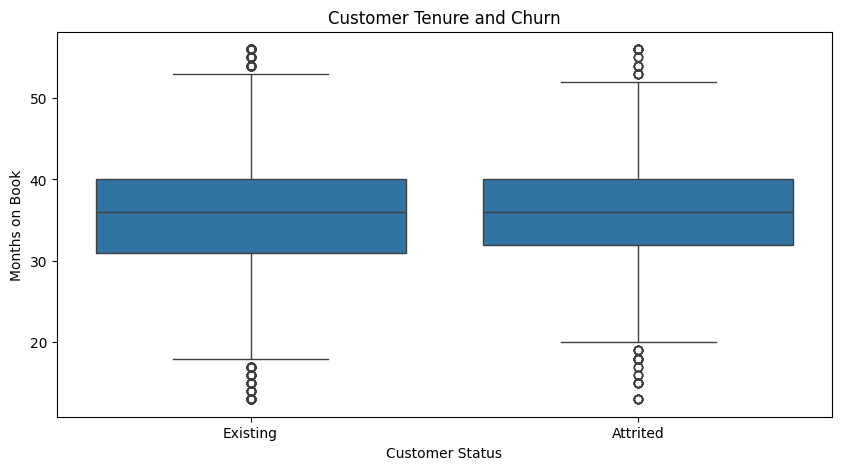

In [51]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_eda['attrition_flag'], y=train_eda['months_on_book'])
plt.xticks([0, 1], ['Existing', 'Attrited'])
plt.title('Customer Tenure and Churn')
plt.xlabel('Customer Status')
plt.ylabel('Months on Book')
plt.show()

In [52]:
# I use Pearson’s correlation (Pearson's r) because I'm analyzing the linear relationship between two continuous variables (tenure & churn).

corr_tenure, p_tenure = pearsonr(train_eda['months_on_book'], train_eda['attrition_flag'])
print(f"Correlation between Tenure and Churn: r = {corr_tenure:.4f}, p-value = {p_tenure:.4f}")

Correlation between Tenure and Churn: r = 0.0108, p-value = 0.3298


- Interpretation of the Correlation Results:
  - Correlation coefficient (r) = 0.0108 → This is very close to 0, meaning there is almost no linear relationship between months_on_book (tenure) and attrition_flag (churn).
  - p-value = 0.3298 → Since this is greater than 0.05, the correlation is not statistically significant. This means we fail to reject the null hypothesis, indicating that **tenure does not have a strong impact on churn**.
- Interpretation of the Boxplot:
  - The median tenure (middle line in the box) for both Existing and Attrited customers appears similar.
  - The spread (interquartile range, IQR) and distribution of tenure are also quite similar between the two groups.
  - This suggests that customers who have been with the bank for a long time are just as likely to churn as newer customers.

**Summary**
- A longer tenure does NOT significantly reduce churn probability.
- Customers who have been with the bank for a long time can still churn, contradicting the assumption that long-term customers are more loyal.

**5. Apakah semakin sering customer berinteraksi dengan bank dalam 1 tahun terakhir mempengaruhi besar atau kecilnya kemungkinan nasabah untuk churn?**

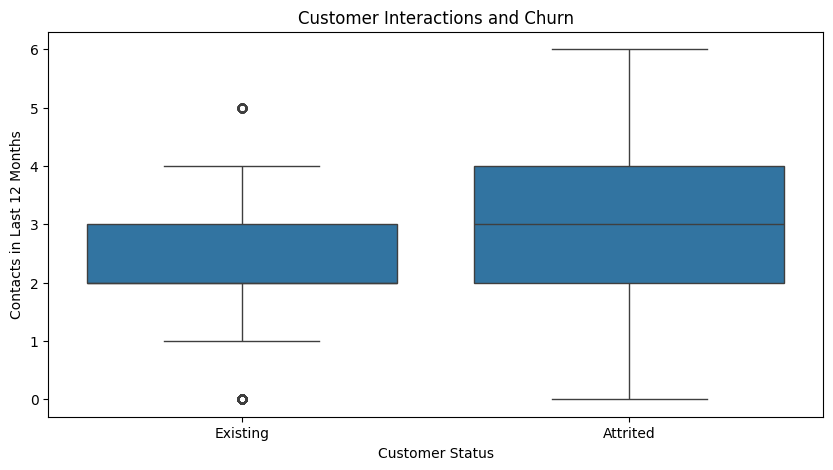

In [53]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_eda['attrition_flag'], y=train_eda['contacts_count_12_mon'])
plt.xticks([0, 1], ['Existing', 'Attrited'])
plt.title('Customer Interactions and Churn')
plt.xlabel('Customer Status')
plt.ylabel('Contacts in Last 12 Months')
plt.show()

In [54]:
# I use Pearson’s correlation (Pearson's r) because I'm analyzing the linear relationship between two continuous variables (contacts & churn).
corr_contacts, p_contacts = pearsonr(train_eda['contacts_count_12_mon'], train_eda['attrition_flag'])
print(f"Correlation between Contacts and Churn: r = {corr_contacts:.4f}, p-value = {p_contacts:.4f}")

Correlation between Contacts and Churn: r = 0.2083, p-value = 0.0000


- Interpretation of the Correlation Results:
  - Correlation coefficient (r) = 0.2083 → This indicates a weak positive correlation between the number of contacts in the last 12 months and churn. While not a strong relationship, it suggests that **customers who interact more with the bank tend to churn slightly more often**.
  - p-value = 0.0000 → Since this is far below 0.05, the correlation is statistically significant, meaning the relationship is not due to random chance.
- Interpretation of the Boxplot:
  - Attrited customers (right boxplot) generally have a higher median number of contacts than existing customers.
  - The spread (IQR) for attrited customers is wider, indicating more variability in the number of contacts.
  - Some attrited customers had very few interactions, but many had more interactions than existing customers.

**Summary**
- More frequent interactions with the bank are associated with a higher likelihood of churn.
- This could suggest that customers who frequently contact the bank may be experiencing issues, dissatisfaction, or inquiries about closing their accounts.
- Banks should investigate why these high-contact customers are leaving and consider strategies such as improved customer support or personalized engagement to retain them.

## Categorical Data vs Attrited

In [55]:
def prop_agg(df, y, x):
  temp_df = df.groupby([y,x], as_index = False).size()
  temp_df['prop'] = temp_df['size'] / temp_df.groupby(y)['size'].transform('sum')
  return temp_df

In [56]:
prop_agg(train, "gender", "attrition_flag")

,gender,attrition_flag,size,prop
0,F,Attrited Customer,745,0.174801
1,F,Existing Customer,3517,0.825199
2,M,Attrited Customer,557,0.145090
3,M,Existing Customer,3282,0.854910


**gender vs attrition_flag**

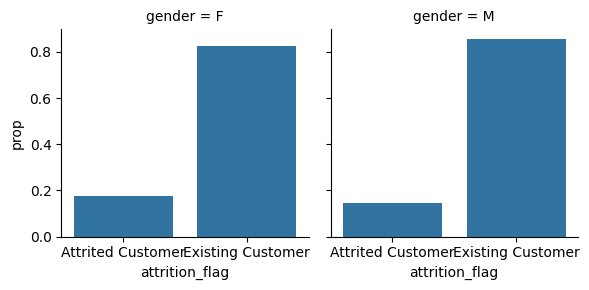

In [57]:
g = sns.FacetGrid(
    data = prop_agg(train, "gender", "attrition_flag"),
    col = "gender"
)
g.map(sns.barplot, "attrition_flag", "prop");

**Insight**
- xx
- xx

**education_level vs attrition_flag**

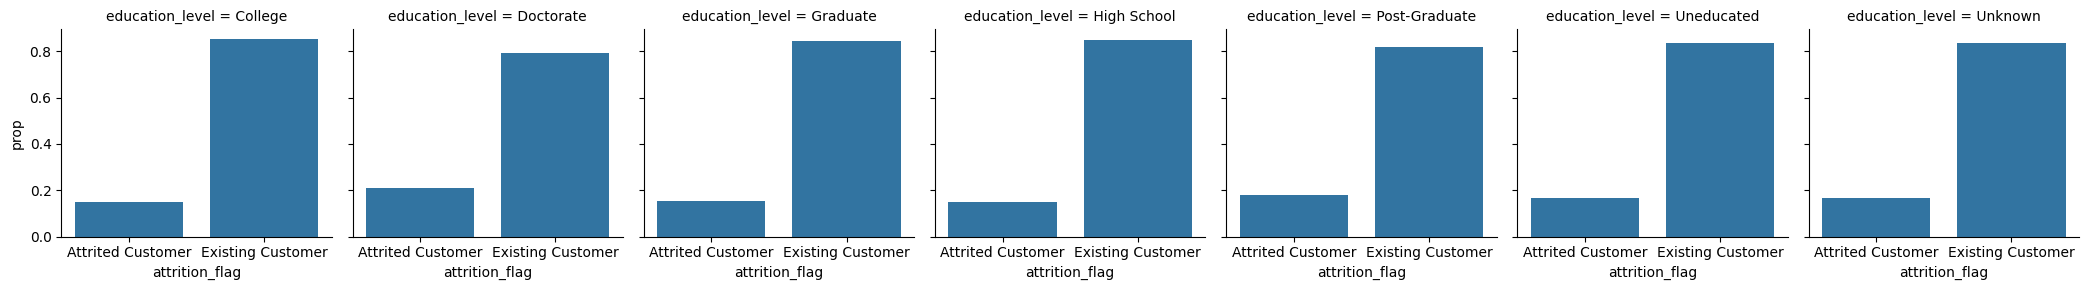

In [58]:
g = sns.FacetGrid(
    data = prop_agg(train, "education_level", "attrition_flag"),
    col = "education_level"
)
g.map(sns.barplot, "attrition_flag", "prop");

**Insight**
- xx
- xx

**marital_status vs attrition_flag**

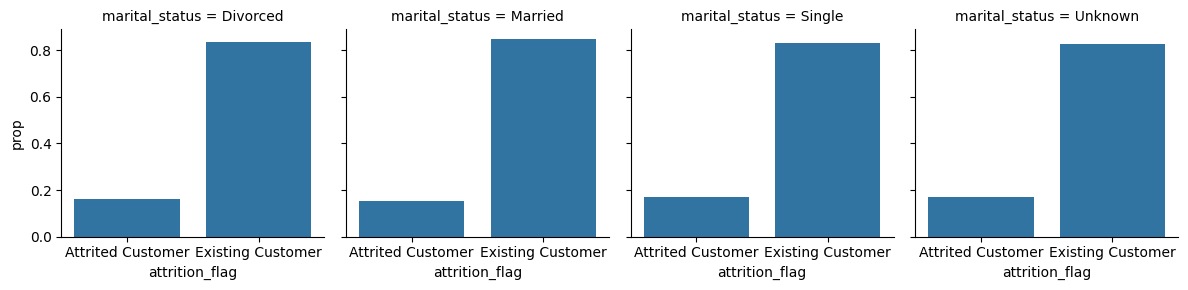

In [59]:
g = sns.FacetGrid(
    data = prop_agg(train, "marital_status", "attrition_flag"),
    col = "marital_status"
)
g.map(sns.barplot, "attrition_flag", "prop");

**Insight**
- xx
- xx

**income_category vs attrition_flag**

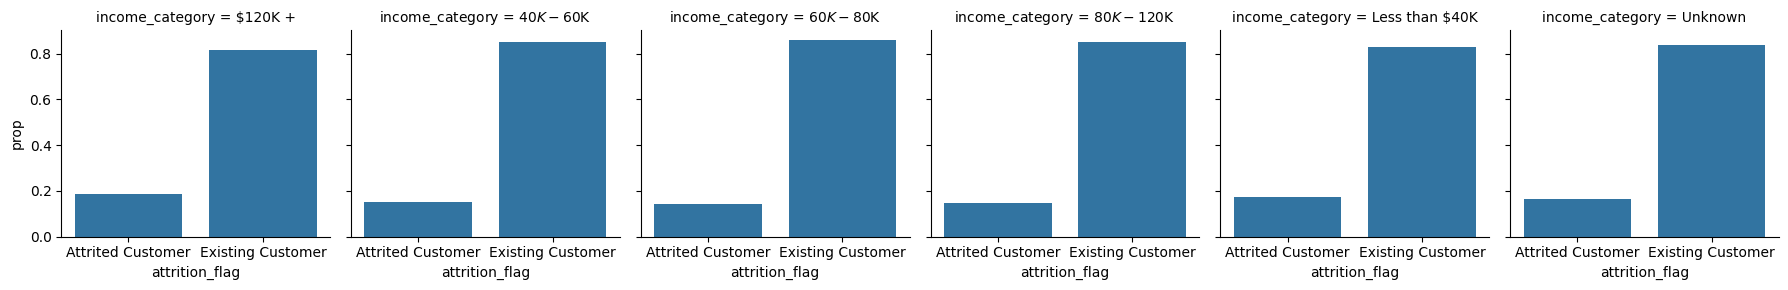

In [60]:
g = sns.FacetGrid(
    data = prop_agg(train, "income_category", "attrition_flag"),
    col = "income_category"
)
g.map(sns.barplot, "attrition_flag", "prop");

**Insight**
- xx
- xx

**card_category vs attrition_flag**

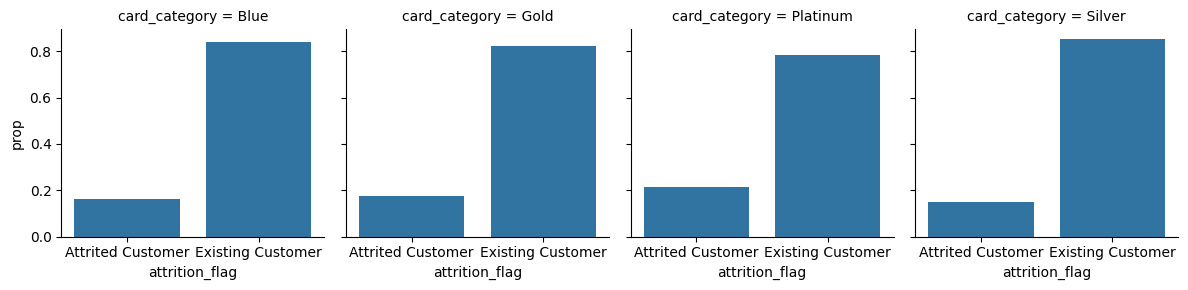

In [61]:
g = sns.FacetGrid(
    data = prop_agg(train, "card_category", "attrition_flag"),
    col = "card_category"
)
g.map(sns.barplot, "attrition_flag", "prop");

**Insight**
- xx
- xx

## Numerical Data vs Attrited

**customer_age vs attrition_flag**

In [62]:
# sns.boxplot(x = "attrition_flag", y = "customer_age", data = train);

**Insight**
- xxx
- xxx



**dependent_count vs attrition_flag**

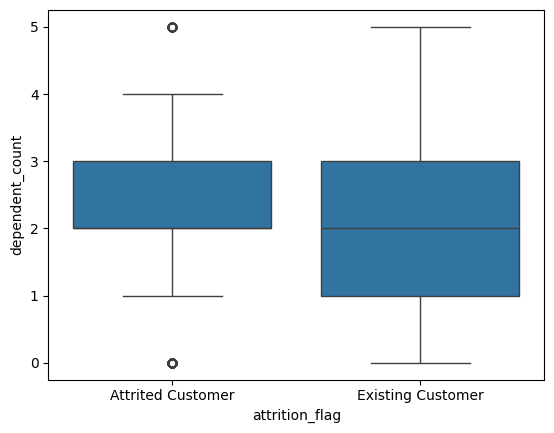

In [63]:
sns.boxplot(x = "attrition_flag", y = "dependent_count", data = train);

**Insight**
- xxx
- xxx



**months_on_book vs attrition_flag**

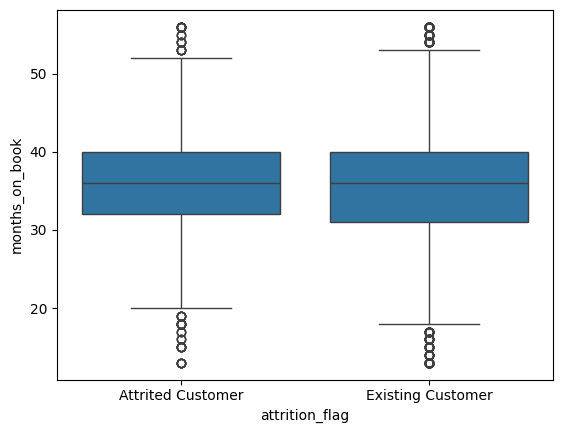

In [64]:
sns.boxplot(x = "attrition_flag", y = "months_on_book", data = train);

**Insight**
- xxx
- xxx



**total_relationship_count vs attrition_flag**

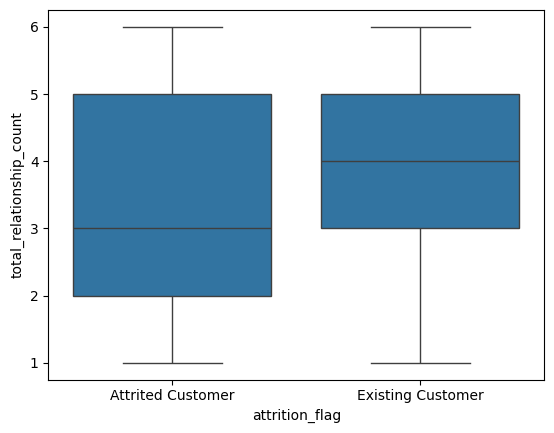

In [65]:
sns.boxplot(x = "attrition_flag", y = "total_relationship_count", data = train);

**Insight**
- xxx
- xxx



**months_inactive_12_mon vs attrition_flag**

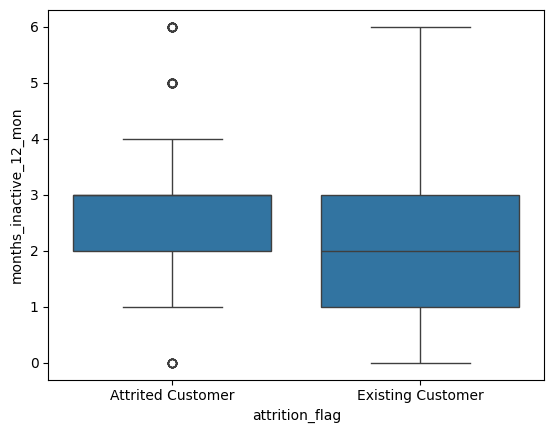

In [66]:
sns.boxplot(x = "attrition_flag", y = "months_inactive_12_mon", data = train);

**Insight**
- xxx
- xxx



**contacts_count_12_mon vs attrition_flag**

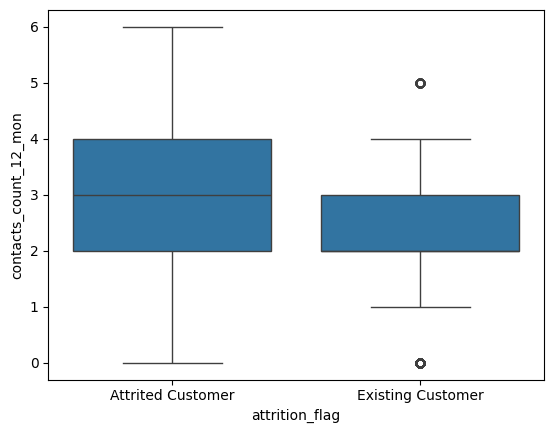

In [67]:
sns.boxplot(x = "attrition_flag", y = "contacts_count_12_mon", data = train);

**Insight**
- xxx
- xxx



**credit_limit vs attrition_flag**

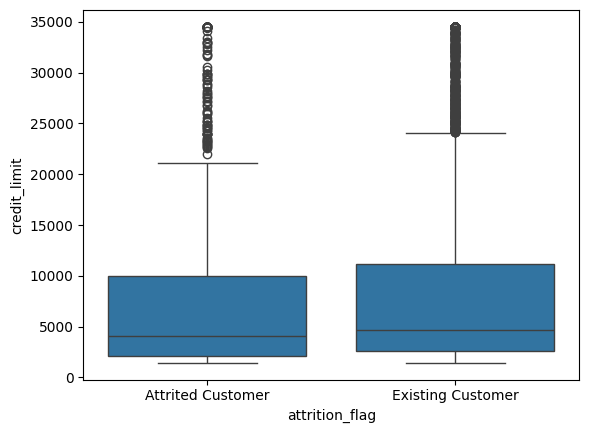

In [68]:
sns.boxplot(x = "attrition_flag", y = "credit_limit", data = train);

**Insight**
- xxx
- xxx



**total_revolving_bal vs attrition_flag**

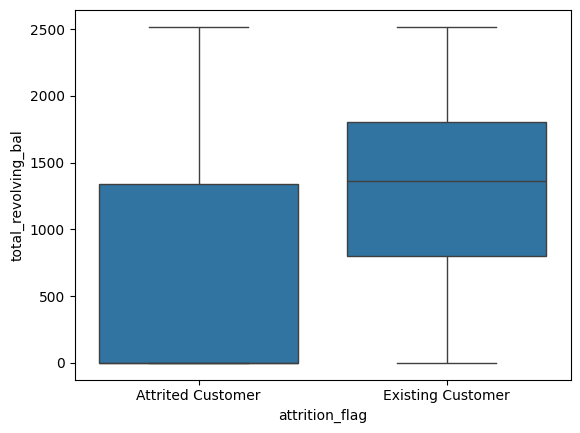

In [69]:
sns.boxplot(x = "attrition_flag", y = "total_revolving_bal", data = train);

**Insight**
- xxx
- xxx



**avg_open_to_buy vs attrition_flag**

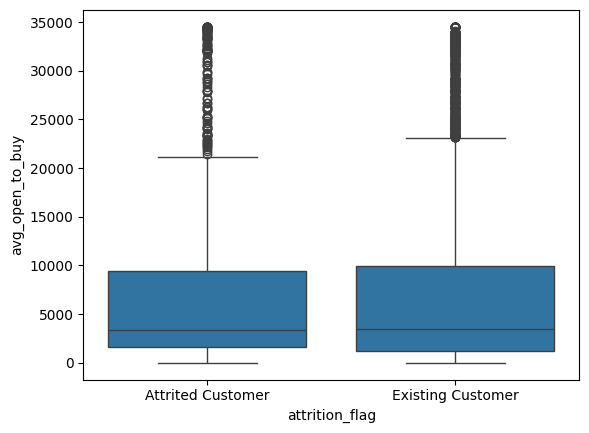

In [70]:
sns.boxplot(x = "attrition_flag", y = "avg_open_to_buy", data = train);

**Insight**
- xxx
- xxx



**total_amt_chng_q4_q1 vs attrition_flag**

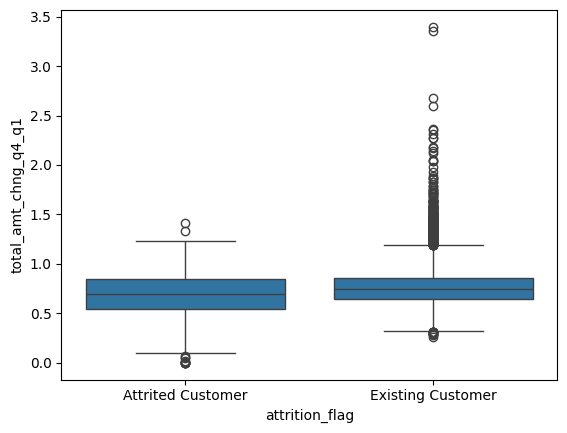

In [71]:
sns.boxplot(x = "attrition_flag", y = "total_amt_chng_q4_q1", data = train);

**Insight**
- xxx
- xxx



**total_trans_amt vs attrition_flag**

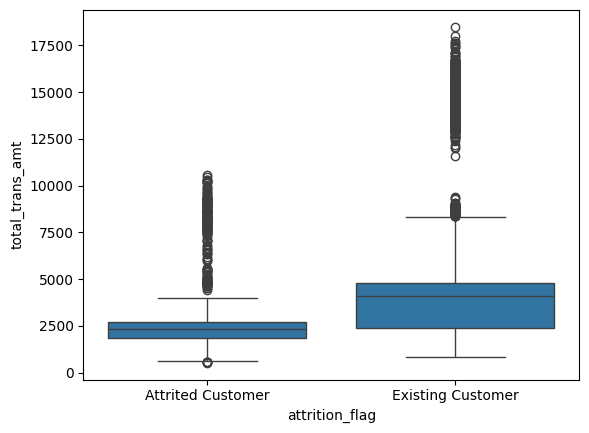

In [72]:
sns.boxplot(x = "attrition_flag", y = "total_trans_amt", data = train);

**Insight**
- xxx
- xxx



**total_trans_ct vs attrition_flag**

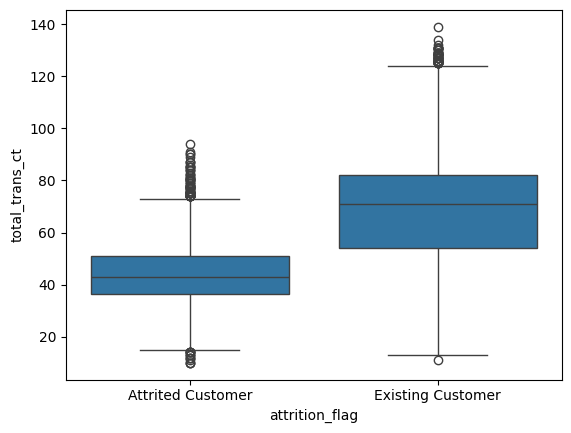

In [73]:
sns.boxplot(x = "attrition_flag", y = "total_trans_ct", data = train);

**Insight**
- xxx
- xxx



**total_ct_chng_q4_q1 vs attrition_flag**

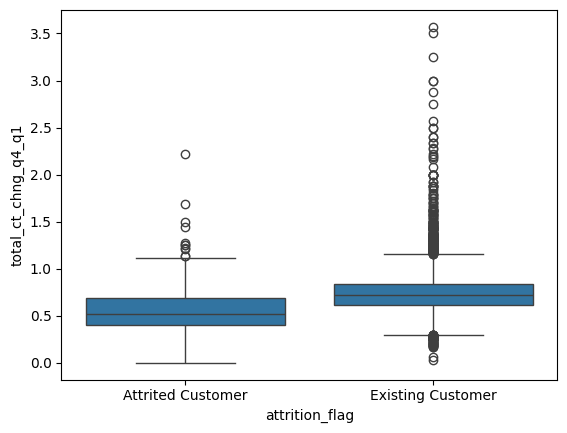

In [74]:
sns.boxplot(x = "attrition_flag", y = "total_ct_chng_q4_q1", data = train);

**Insight**
- xxx
- xxx



**avg_utilization_ratio vs attrition_flag**

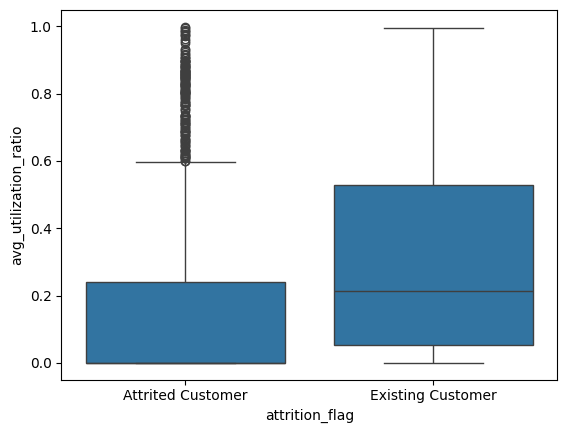

In [75]:
sns.boxplot(x = "attrition_flag", y = "avg_utilization_ratio", data = train);

**Insight**
- xxx
- xxx



## Correlation Matrix and VIF

I group the correlation strength into the following categories:
- Strong: Correlation strength ≥ 0.8 or ≤ -0.8
- Moderate: 0.3 < correlation strength < 0.8 or -0.8 < correlation strength < -0.3
- Weak: Correlation strength ≤ 0.3 and ≥ -0.3

In [76]:
def num_corr(df, corr_name='Correlation Matrix'):
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 6))
    correlation = df.corr(numeric_only=True)
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm', annot_kws={"size": 11})
    sns.despine(left=True, bottom=True)
    plt.grid(False)
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.title(f"{corr_name}", fontsize=16, fontweight='bold')

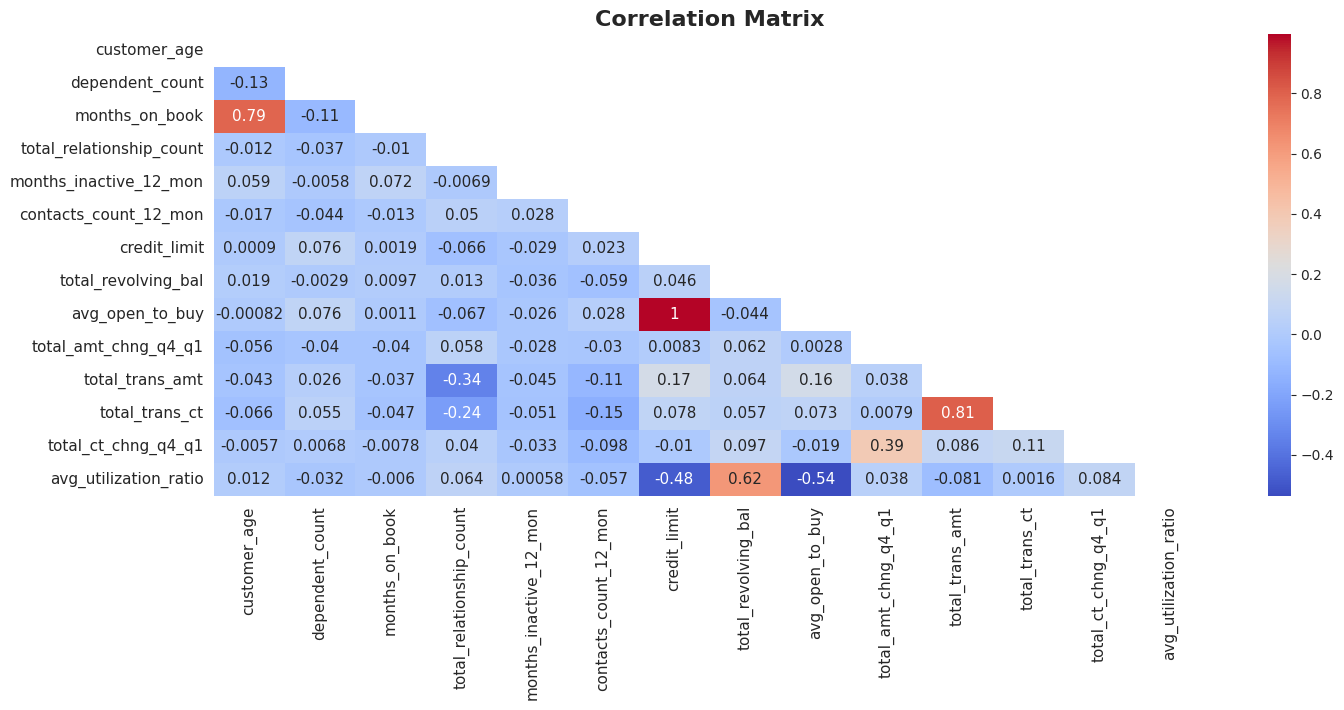

In [77]:
num_corr(train)

**Insight**
- xx
- xx

---

I group the strength of VIF into the following categories:
- No multicollinearity: VIF = 1
- Moderate multicollinearity: 5 ≤ VIF ≤ 10
- Severe multicollinearity: VIF > 10

In [78]:
# Calculate VIF for each feature

X_vif = train.drop(columns='attrition_flag')
X_vif = X_vif.select_dtypes(include='number')

# Add a constant to the DataFrame (required for VIF calculation)
X_vif = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df

,feature,VIF
7,credit_limit,inf
8,total_revolving_bal,inf
9,avg_open_to_buy,inf
11,total_trans_amt,3.244615
12,total_trans_ct,3.016457
14,avg_utilization_ratio,2.889834
1,customer_age,2.671557
3,months_on_book,2.648655
13,total_ct_chng_q4_q1,1.214270
10,total_amt_chng_q4_q1,1.197291


In [79]:
# Drop the "avg_open_to_buy" feature
train = train.drop(columns=['avg_open_to_buy', 'customer_age', 'total_trans_amt'])
test = test.drop(columns=['avg_open_to_buy', 'customer_age', 'total_trans_amt'])

In [80]:
# Calculate VIF for each feature

X_vif = train.drop(columns='attrition_flag')
X_vif = X_vif.select_dtypes(include='number')

# Add a constant to the DataFrame (required for VIF calculation)
X_vif = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df

,feature,VIF
11,avg_utilization_ratio,2.855023
7,total_revolving_bal,2.203086
6,credit_limit,1.761716
10,total_ct_chng_q4_q1,1.213584
8,total_amt_chng_q4_q1,1.189032
9,total_trans_ct,1.111358
3,total_relationship_count,1.072894
5,contacts_count_12_mon,1.037929
1,dependent_count,1.024316
2,months_on_book,1.022070


From the table, we can see that the VIF score is around 1 or 2, which means there is no moderate multicollinearity. Therefore, there is no multicollinearity issue here.

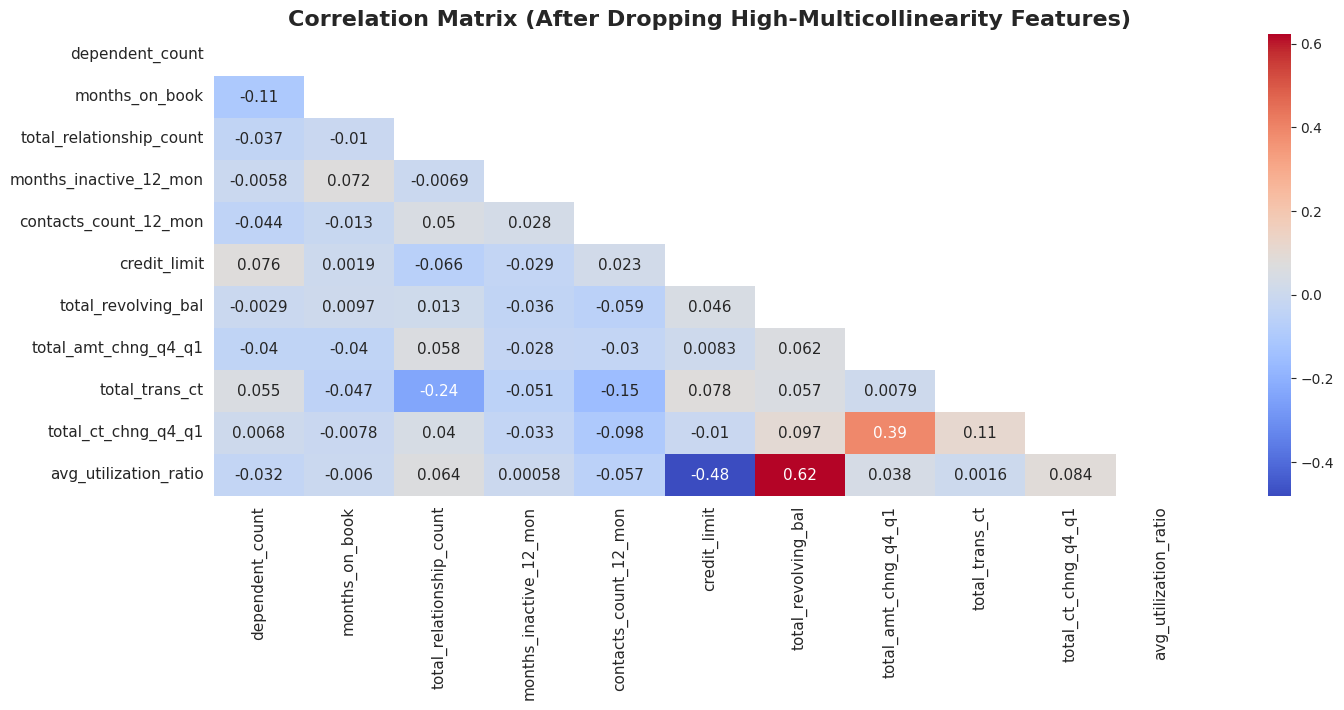

In [81]:
num_corr(train, 'Correlation Matrix (After Dropping High-Multicollinearity Features)')

**Note**
- I have conducted an experiment in the Experiment section, dropping high multicollinearity features (`avg_open_to_buy`, `customer_age`, `total_trans_amt`). The results indicate that this decreases the performance metrics for all models. However, it is still necessary to drop these features because high multicollinearity complicates model interpretation. For instance, it may become challenging to determine which feature is truly important due to the overlapping information they provide. Therefore, I will proceed with dropping these features.

# Feature Engineering

## Feature Encoding

### Label Encoding

In [82]:
# Initialize a dictionary to store encoders for each column
encoders = {}

# Encode categorical columns in the training set
for col in ['gender']:
    encoders[col] = LabelEncoder()  # Create a new LabelEncoder for each column
    train[col] = encoders[col].fit_transform(train[col])

# Transform categorical columns in the test set using the same encoders
for col in ['gender']:
    test[col] = encoders[col].transform(test[col])  # Use the same encoders trained on train set

In [83]:
# Encode attrition_flag
train['attrition_flag'] = train['attrition_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})
test['attrition_flag'] = test['attrition_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

### One-Hot Encoding (Dummy Encoding Version)

Since I'm unsure about the hierarchy of the `card_type` (e.g., whether the lowest is blue or silver), I opted for one-hot encoding instead of ordinal encoding.

Regarding the **Unknown** entries in `educational_level` and `income_category`, using ordinal encoding could potentially disrupt the relationships because the Unknown category lacks a natural order. To address this issue, it would be better to use one-hot encoding to treat each category as independent, thereby avoiding misrepresentation in the data.

In [84]:
categorical_columns = ['marital_status', 'card_category', 'education_level', 'income_category']

In [85]:
train = pd.get_dummies(train, columns=categorical_columns, dtype=int, drop_first=True)
test = pd.get_dummies(test, columns=categorical_columns, dtype=int, drop_first=True)

**Check all types of encoding**

In [86]:
# To display all columns in a pandas DataFrame
pd.set_option('display.max_columns', None)  # Show all columns

In [87]:
df.loc[[1602, 7791	, 7177]]

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
1602,Attrited Customer,54,F,3,College,Single,Unknown,Blue,49,6,2,3,13184.0,0,13184.0,1.166,2047,33,0.179,0.000
7791,Existing Customer,51,M,0,High School,Single,$80K - $120K,Blue,45,3,2,3,10648.0,2517,8131.0,0.708,4930,89,0.978,0.236
7177,Existing Customer,45,F,4,High School,Single,$40K - $60K,Blue,29,3,2,1,4595.0,1781,2814.0,0.708,3746,68,0.545,0.388


In [88]:
train.head(3)

,gender,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,attrition_flag,marital_status_Married,marital_status_Single,marital_status_Unknown,card_category_Gold,card_category_Platinum,card_category_Silver,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,education_level_Unknown,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,income_category_Unknown
1602,0,3,49,6,2,3,13184.0,0,1.166,33,0.179,0.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7791,1,0,45,3,2,3,10648.0,2517,0.708,89,0.978,0.236,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
7177,0,4,29,3,2,1,4595.0,1781,0.708,68,0.545,0.388,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [89]:
df.loc[[9242, 7036, 914	]]

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
9242,Existing Customer,47,M,3,Graduate,Single,$60K - $80K,Silver,36,1,1,2,30498.0,1990,28508.0,0.839,16202,120,0.791,0.065
7036,Existing Customer,51,M,1,High School,Married,Less than $40K,Blue,41,3,4,3,1438.3,0,1438.3,0.623,4312,81,0.723,0.000
914,Existing Customer,55,M,2,College,Married,$80K - $120K,Blue,45,5,1,2,2929.0,2431,498.0,1.632,1903,39,0.625,0.830


In [90]:
test.head(3)

,gender,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,attrition_flag,marital_status_Married,marital_status_Single,marital_status_Unknown,card_category_Gold,card_category_Platinum,card_category_Silver,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,education_level_Unknown,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,income_category_Unknown
9242,1,3,36,1,1,2,30498.0,1990,0.839,120,0.791,0.065,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
7036,1,1,41,3,4,3,1438.3,0,0.623,81,0.723,0.000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
914,1,2,45,5,1,2,2929.0,2431,1.632,39,0.625,0.830,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [91]:
# Resets max columns setting
pd.reset_option('display.max_columns')

## Feature Scaling

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 1602 to 3640
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          8101 non-null   int64  
 1   dependent_count                 8101 non-null   int64  
 2   months_on_book                  8101 non-null   int64  
 3   total_relationship_count        8101 non-null   int64  
 4   months_inactive_12_mon          8101 non-null   int64  
 5   contacts_count_12_mon           8101 non-null   int64  
 6   credit_limit                    8101 non-null   float64
 7   total_revolving_bal             8101 non-null   int64  
 8   total_amt_chng_q4_q1            8101 non-null   float64
 9   total_trans_ct                  8101 non-null   int64  
 10  total_ct_chng_q4_q1             8101 non-null   float64
 11  avg_utilization_ratio           8101 non-null   float64
 12  attrition_flag                  8101

In [93]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 9242 to 8014
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          2026 non-null   int64  
 1   dependent_count                 2026 non-null   int64  
 2   months_on_book                  2026 non-null   int64  
 3   total_relationship_count        2026 non-null   int64  
 4   months_inactive_12_mon          2026 non-null   int64  
 5   contacts_count_12_mon           2026 non-null   int64  
 6   credit_limit                    2026 non-null   float64
 7   total_revolving_bal             2026 non-null   int64  
 8   total_amt_chng_q4_q1            2026 non-null   float64
 9   total_trans_ct                  2026 non-null   int64  
 10  total_ct_chng_q4_q1             2026 non-null   float64
 11  avg_utilization_ratio           2026 non-null   float64
 12  attrition_flag                  2026

In [94]:
X_train = train.drop(['attrition_flag'], axis = 1)
y_train = train['attrition_flag']

X_test = test.drop(['attrition_flag'], axis = 1)
y_test = test['attrition_flag']

I will conduct an experiment with the StandardScaler. However, as we know, tree-based models rely on splitting logic rather than comparing feature scales with one another. This experiment will help determine whether applying feature scaling has any impact on performance.

In [95]:
# # Initialize the StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

**Note**
- I have conducted experiments using the StandardScaler in the Experiment section, and the results indicate that it slightly improves the performance metrics for the Decision Tree and LightGBM models. However, it has no effect on XGBoost and decreases the performance metrics of the Random Forest model. Since the impact of the StandardScaler is not significant across the models, I have decided not to apply it.

# Model Building and Selection

## Question 2 and 3

**2. Buatlah model prediksi dengan menggunakan model machine learning (bebas, tidak dibatasi) dan evaluasi seberapa baik model yang anda buat. Catatan: soal ini akan dinilai berdasarkan apakah mentee sudah menggunakan workflow dengan benar**

**3. Anda ingin meyakinkan stakeholder anda bahwa model yang anda gunakan itu akan lebih baik dalam mengidentifikasi customer yang akan churn dibandingkan tanpa menggunakan model. Apa metrik yang dapat anda gunakan untuk membuktikan hal ini? Visualkan!**

**Interchangeably**<br>
Attrited customer = Churners<br>
Existing customer = Non-churners

**With or without a model?**

Processing thousands of rows of data to identify churned customers is challenging without a machine learning model, as patterns may not be easily visible. A machine learning model enables efficient and automated analysis, allowing us to detect churn patterns quickly and accurately.

**Chosen Metrics**:
- Recall
- optimized threshold using PR AUC
- F1-Score

Since false negatives (missed churners) are more costly, we must prioritize metrics that:
- Maximize churn detection (Recall) → Ensures we catch as many churners as possible to prevent revenue loss.
- Optimize threshold using PR AUC → Precision-Recall AUC focuses only on the churn class, making it ideal for imbalanced datasets.
- Balance Recall & Precision with F1-Score → Ensures we minimize false positives while keeping recall high, avoiding unnecessary retention costs.

Why Not Just Accuracy or ROC AUC?
- Accuracy is misleading in imbalanced datasets (predicting "non-churn" always gives high accuracy).
- ROC AUC considers both classes, but PR AUC is better when the minority class (churners) is the focus.

Business Impact:
- High Recall → Fewer lost customers.
- PR AUC → Best threshold to minimize false negatives.
- F1-Score → Ensures a good balance without excessive false positives.

This approach maximizes retention efforts while controlling costs, making it the most effective strategy for churn prevention.

**I choose these models (tree-based models)**:
- DecisionTreeClassifier
- RandomForestClassifier
- LightGBMClassifier
- XGBClassifier

Tree-based models are ideal for churn prediction because they:
- Handle non-linearity: Capture complex relationships in customer behavior.
- Work with mixed data types: No need for extensive preprocessing.
- Are robust to missing values & outliers: Unlike linear models.
- Perform well on imbalanced data: Using class weighting & boosting techniques.
- Provide feature importance insights: Explain why customers churn.
- Scale efficiently: LightGBM & XGBoost are optimized for large datasets.

In [96]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss")
}

# XGBoost -> logloss: best for binary classification when probability calibration matters.

## Experiment

In [97]:
results = []

# Colors for each model
colors = ["blue", "green", "orange", "purple"]

# Store the model names and explainer objects for later use
explainers = {}

print("==== Recall, Precision, F1 Scores & Classification Reports ====")

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict class labels

    recall = recall_score(y_test, y_pred)  # Compute recall
    precision = precision_score(y_test, y_pred)  # Compute precision
    f1 = f1_score(y_test, y_pred)  # Compute F1 score

    print(f"\n== {name} - Recall: {recall:.4f}, Precision: {precision:.4f}, F1: {f1:.4f}")
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    # Append results to the list
    results.append([name, f'{recall:.4f}', f'{precision:.4f}', f'{f1:.4f}'])

    # Save the Explainer object
    model_name = dx.Explainer(model, X_train, y_train, label=name, verbose=False)
    explainers[name] = model_name  # Store the explainers for later use

==== Recall, Precision, F1 Scores & Classification Reports ====

== Decision Tree - Recall: 0.6954, Precision: 0.6726, F1: 0.6838

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1701
           1       0.67      0.70      0.68       325

    accuracy                           0.90      2026
   macro avg       0.81      0.82      0.81      2026
weighted avg       0.90      0.90      0.90      2026


== Random Forest - Recall: 0.6708, Precision: 0.8651, F1: 0.7556

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1701
           1       0.87      0.67      0.76       325

    accuracy                           0.93      2026
   macro avg       0.90      0.83      0.86      2026
weighted avg       0.93      0.93      0.93      2026


== LightGBM - Recall: 0.7538, Precision: 0.8390, F1: 0.7942

Cl

In [98]:
# print("\n==== Permutation Feature Importance Plots ====")

# for name, explainer in explainers.items():
#     # Plot permutation feature importance for each model
#     print(f"\nPlotting permutation feature importance for {name}...")
#     explainer.model_parts().plot()

In [99]:
# print("\n==== Partial Dependence Plots ====")
# for name, explainer in explainers.items():
#     # Plot partial dependence plot for each model
#     print(f"\nPlotting partial dependence plot for {name}...")
#     explainer.model_profile().plot()

In [100]:
# Convert results to a DataFrame
df_results_exp = pd.DataFrame(results, columns=["Model", "Recall", "Precision", "F1-Score"])

In [101]:
df_results_exp

,Model,Recall,Precision,F1-Score
0,Decision Tree,0.6954,0.6726,0.6838
1,Random Forest,0.6708,0.8651,0.7556
2,LightGBM,0.7538,0.8390,0.7942
3,XGBoost,0.7692,0.8389,0.8026


**Baseline Model**

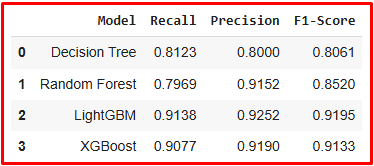

This is the result of the baseline model.

**Baseline Model + a New Feature (CES) ✘**

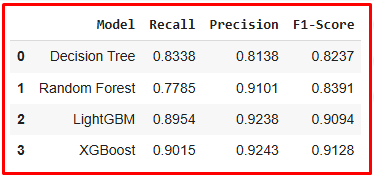

From these results, we can see that creating the new feature, CES (Customer Engagement Score), improves the performance metrics for the Decision Tree but decreases them for the other tree-based models (Random Forest, LightGBM, XGBoost). Therefore, I have decided not to use this new feature.

**Baseline Model + Dropping a high-multicollinearity (avg_open_to_buy) ✓**

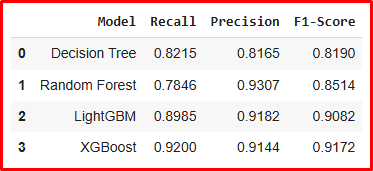

I provide the explanation below.

**Baseline Model + Dropping a high-multicollinearity (avg_open_to_buy + customer_age) ✓**

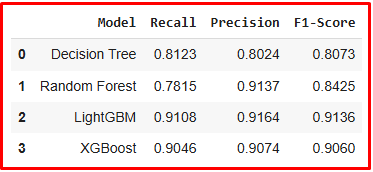

I provide the explanation below.

**Baseline Model + Dropping a high-multicollinearity (avg_open_to_buy + customer_age + total_trans_amt) ✓**

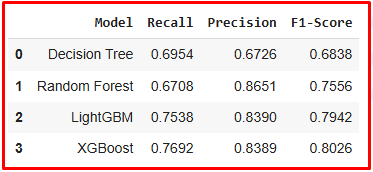

From these results, we can see that dropping features with very high multicollinearity (correlation strength > 0.8), such as `avg_open_to_buy`, `customer_age`, and `total_trans_amt`, decreases the performance metrics for all models. However, it is still necessary to drop these features because high multicollinearity can complicate model interpretation. For example, it may become challenging to determine which feature is truly important due to the overlapping information they provide. Therefore, I will proceed with dropping these features.

**Baseline Model + Dropping a high-multicollinearity (avg_open_to_buy + customer_age + total_trans_amt + StandardScaler) ✘**

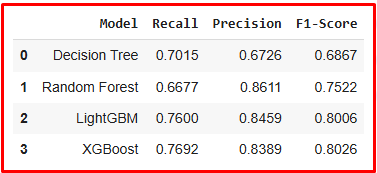

From the table above, we can observe that applying the StandardScaler slightly improves the performance metrics for the Decision Tree and LightGBM models. However, it has no noticeable effect on XGBoost and decreases the performance metrics of the Random Forest model. Since the impact of StandardScaler is not significant across the models, I have decided not to apply it.

**Baseline Model + Dropping a high-multicollinearity (avg_open_to_buy + customer_age + total_trans_amt + StandardScaler + Skewness Transsformation) ✘**

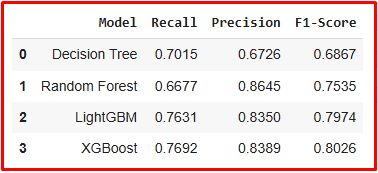

From the table above, we can observe that applying the Skewness Transformation slightly improves the performance metrics for the Random Forest and LightGBM models. However, it has no noticeable effect on the Decision Tree and XGBoost models. Since the overall impact of the Skewness Transformation is not significant across the models, I have decided not to apply it.

Additionally, applying the transformation would make it less intuitive to interpret the relationship between input features and output predictions, as the real-world influence of the features would need to be analyzed with the transformation in mind.

## Minimizing False Negatives by Adjusting the Threshold

==== Best Threshold, F1-Score & Classification Reports ====

== Training Decision Tree...
Decision Tree training completed.
Decision Tree - Recall: 0.6954, Precision: 0.6726, F1-Score: 0.6838, Best Threshold: 1.0000

 Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1701
           1       0.67      0.70      0.68       325

    accuracy                           0.90      2026
   macro avg       0.81      0.82      0.81      2026
weighted avg       0.90      0.90      0.90      2026



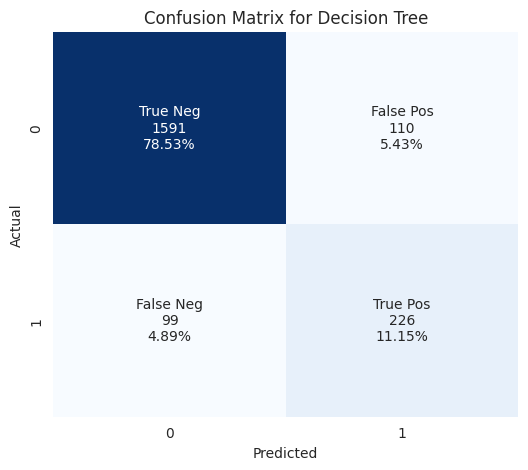


== Training Random Forest...
Random Forest training completed.
Random Forest - Recall: 0.7569, Precision: 0.7961, F1-Score: 0.7760, Best Threshold: 0.3800

 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1701
           1       0.80      0.76      0.78       325

    accuracy                           0.93      2026
   macro avg       0.88      0.86      0.87      2026
weighted avg       0.93      0.93      0.93      2026



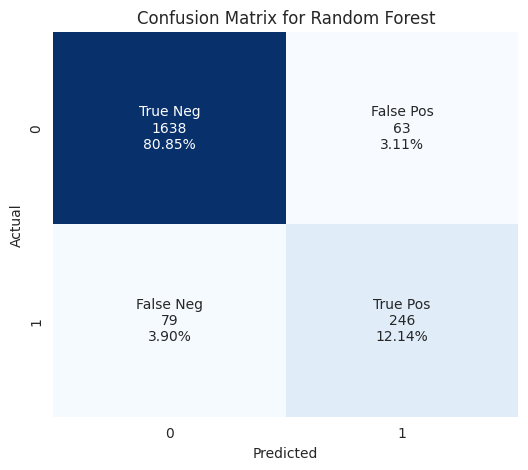


== Training LightGBM...
LightGBM training completed.
LightGBM - Recall: 0.8062, Precision: 0.8187, F1-Score: 0.8124, Best Threshold: 0.4146

 Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1701
           1       0.82      0.81      0.81       325

    accuracy                           0.94      2026
   macro avg       0.89      0.89      0.89      2026
weighted avg       0.94      0.94      0.94      2026



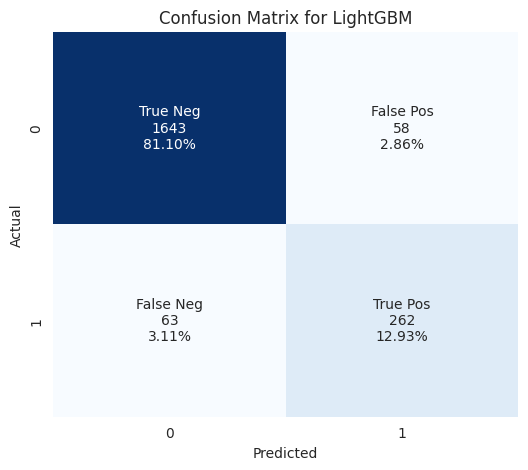


== Training XGBoost...
XGBoost training completed.
XGBoost - Recall: 0.8246, Precision: 0.8000, F1-Score: 0.8121, Best Threshold: 0.3437

 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1701
           1       0.80      0.82      0.81       325

    accuracy                           0.94      2026
   macro avg       0.88      0.89      0.89      2026
weighted avg       0.94      0.94      0.94      2026



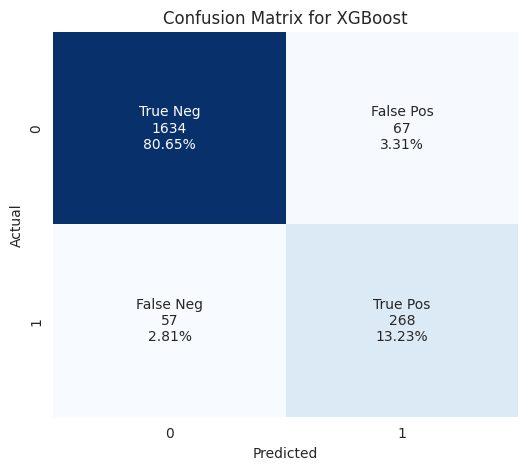

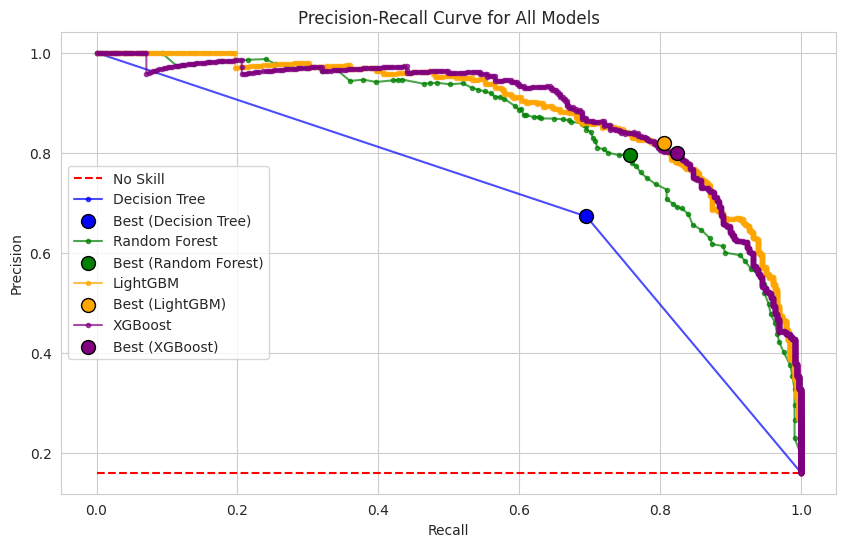

In [102]:
# Assign unique colors for each model
colors = ["blue", "green", "orange", "purple"]

# Store Metrics in a DataFrame
results = []

# Store precision-recall curves
precision_recall_data = []

# Store the model names and explainer objects for later use
explainers = {}

# Train Models & Compute Best Threshold using Precision-Recall Curve
print("==== Best Threshold, F1-Score & Classification Reports ====")

# No Skill Baseline Calculation
no_skill = len(y_test[y_test == 1]) / len(y_test)

# Store Precision-Recall data for plotting later
for i, (name, model) in enumerate(models.items()):
    print(f"\n== Training {name}...")

    model.fit(X_train, y_train)  # Train model
    y_probs = model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class (churners)

    # Calculate Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Compute F1 Score for each threshold
    fscore = (2 * precision * recall) / (precision + recall)
    fscore = np.nan_to_num(fscore)  # Handle division by zero errors

    best_index = argmax(fscore)

    best_thresh = thresholds[best_index]

    # Apply the best threshold to make final predictions
    y_pred_adjusted = (y_probs >= best_thresh).astype(int)

    # Compute recall after threshold adjustment
    recall_at_best = recall_score(y_test, y_pred_adjusted)

    # Compute precision after threshold adjustment
    precision_at_best = precision_score(y_test, y_pred_adjusted)

    print(f"{name} training completed.")
    print(f"{name} - Recall: {recall_at_best:.4f}, Precision: {precision_at_best:.4f}, F1-Score: {fscore[best_index]:.4f}, Best Threshold: {best_thresh:.4f}")
    print(f"\n Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred_adjusted))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)

    # Names, counts, and percentages
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot Confusion Matrix using seaborn heatmap with detailed labels
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Show the plot
    plt.show()

    # Store results
    results.append([name, f'{recall_at_best:.4f}', f'{precision_at_best:.4f}', f'{fscore[best_index]:.4f}', f'{best_thresh:.4f}'])

    # Save the Explainer object
    model_name = dx.Explainer(model, X_train, y_train, label=name, verbose=False)
    explainers[name] = model_name  # Store the explainers for later use

    # Store precision-recall curve data for plotting later
    precision_recall_data.append((name, precision, recall, best_index, colors[i]))

# Plot Precision-Recall Curve for all models outside the loop
plt.figure(figsize=(10, 6))  # Initialize plot

# No Skill Baseline Plot
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')

# Plot the precision-recall curves
for name, precision, recall, best_index, color in precision_recall_data:
    plt.plot(recall, precision, marker='.', label=name, color=color, alpha=0.7)
    plt.scatter(recall[best_index], precision[best_index], s=100, marker='o', color=color, edgecolors='black', label=f'Best ({name})', zorder=3)

# Plot Formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Models')
plt.legend()
plt.grid(True)
plt.show()


In [103]:
# Convert Results to DataFrame
df_results_1 = pd.DataFrame(results, columns=["Model", "Recall", "Precision", "F1-Score", "Best Threshold"])

In [104]:
df_results_1

,Model,Recall,Precision,F1-Score,Best Threshold
0,Decision Tree,0.6954,0.6726,0.6838,1.0000
1,Random Forest,0.7569,0.7961,0.7760,0.3800
2,LightGBM,0.8062,0.8187,0.8124,0.4146
3,XGBoost,0.8246,0.8000,0.8121,0.3437


A no-skill model is represented by a horizontal line with a precision equal to the ratio of positive examples in the dataset. A perfect skill classifier achieves full precision and recall, represented by a point in the top-right corner.

In [105]:
# print("\n==== Permutation Feature Importance ====")

# for name, explainer in explainers.items():
#     # Plot permutation feature importance for each model
#     print(f"\nPlotting permutation feature importance for {name}...")
#     explainer.model_parts().plot()

In [106]:
# print("\n==== Partial Dependence Plots ====")
# for name, explainer in explainers.items():
#     # Plot partial dependence plot for each model
#     print(f"\nPlotting partial dependence plot for {name}...")
#     explainer.model_profile().plot()

**Interpretation**

I will evaluate the models based on:
- Recall → Measures how many churners the model correctly identified.
- F1-Score → Balances precision and recall, ensuring both are reasonable.
- Best Threshold → The probability cut-off the model uses to classify customers as churners.

The Logical Flow Behind the Precision-Recall Curve:
- In the case of an imbalanced dataset, the recall tends to be low compared to precision. This is because, with fewer positive instances (e.g., churners), the model might become overly conservative in predicting positives, leading to a higher number of false negatives.
- The Precision-Recall (PR) curve helps us identify the best threshold that maximizes the F1-score, which is the harmonic mean of precision and recall. The F1-score provides a balanced metric that accounts for both precision and recall.
- F1-Score Dynamics:
  - The F1-score is a balance between precision and recall. As we adjust the threshold:
    - Increasing recall generally comes at the cost of decreasing precision. This happens because the model will classify more instances as positive, including more false positives.
    - Decreasing recall tends to increase precision, but risks missing more true positives (i.e., false negatives increase).
- **The primary goal is to increase recall (minimize false negatives) without significantly sacrificing precision**. The optimal threshold is usually where the F1-score is maximized, indicating a good trade-off between improving recall and maintaining an acceptable level of precision.

Best Model: **LightGBM**
- Best balance between Recall (0.6364) & F1-Score (0.6411).
- Threshold: 0.3365 (reasonable, avoids extreme high thresholds like 1.0000 for Decision Tree).
- Performance: LightGBM strikes a strong balance between detecting churners (Recall) and maintaining precision (F1-Score), making it the best overall choice.

Decision Tree:
- Recall = 0.5233 means it misses more churners compared to other models, which could lead to more false negatives.
- F1-Score = 0.4988 indicates a relatively poor balance between precision and recall.
- Threshold = 1.0000 makes it too conservative, classifying almost all customers as non-churners.

Random Forest:
- Offers a solid balance between Recall (0.6118) and Precision (0.6385), with a higher F1-Score than XGBoost.
- Threshold = 0.3600 is slightly higher than LightGBM's, but still reasonable for avoiding extreme low thresholds.
- While not the best model, it provides reliable results, especially if precision is a priority.

XGBoost:
- XGBoost has slightly lower recall and F1-Score compared to LightGBM, but it's close enough that it may still be useful in some situations.


# Hyperparameter Tuning

In [107]:
# Define hyperparameter grids for tuning
param_grids = {
    "Decision Tree": {
        "max_depth": [3, 5, 10, 15, 20, None],  # Control tree depth (None = full depth)
        "min_samples_split": [2, 5, 10, 20],  # Minimum samples needed to split a node
        "min_samples_leaf": [1, 2, 5, 10],  # Adds control over the minimum samples in a leaf
        "class_weight": ["balanced"],  # Adjusts class weights to focus on churners
        "criterion": ["gini", "entropy"]  # Additional parameter to control impurity calculation
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [5, 10, None],  # Maximum tree depth
        "min_samples_split": [2, 5, 10],  # Control overfitting
        "class_weight": ["balanced_subsample"]  # Balances class weights per bootstrap sample
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],  # Boosting rounds
        "learning_rate": [0.01, 0.1, 0.2],  # Lower values improve stability
        "max_depth": [-1, 5, 10],  # `-1` lets LightGBM determine the best depth
        "scale_pos_weight": [5.2],  # Class imbalance ratio (5.2:1)
        "reg_alpha": [0, 0.1, 0.5],  # L1 regularization to prevent overfitting
        "reg_lambda": [0, 0.1, 0.5]  # L2 regularization to prevent overfitting
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200, 500],  # Number of boosting rounds
        "learning_rate": [0.01, 0.1, 0.2],  # Step size for weight updates
        "max_depth": [3, 6, 10],  # Tree depth for complexity control
        "scale_pos_weight": [5.2],  # Balances minority (churners) with majority class
    }
}

==== Best Threshold, F1-Score & Classification Reports ====

== Tuning Decision Tree with GridSearchCV...
Best hyperparameters for Decision Tree: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Training Time for Decision Tree: 25 sec
Decision Tree - Recall: 0.7846, Precision: 0.6855, F1-Score: 0.7317, Best Threshold: 0.7437

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1701
           1       0.69      0.78      0.73       325

    accuracy                           0.91      2026
   macro avg       0.82      0.86      0.84      2026
weighted avg       0.91      0.91      0.91      2026



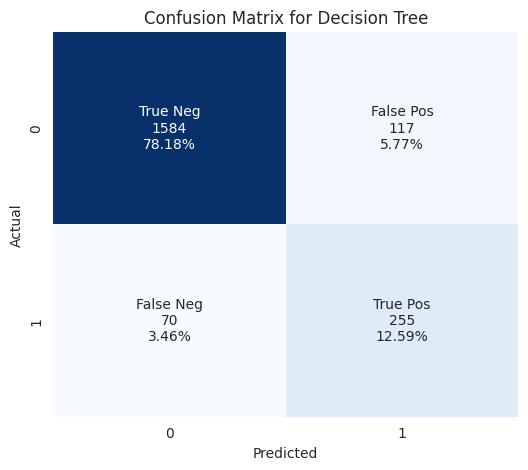


== Tuning Random Forest with GridSearchCV...
Best hyperparameters for Random Forest: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Training Time for Random Forest: 1 min 15 sec
Random Forest - Recall: 0.7908, Precision: 0.7559, F1-Score: 0.7729, Best Threshold: 0.4248

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1701
           1       0.76      0.79      0.77       325

    accuracy                           0.93      2026
   macro avg       0.86      0.87      0.86      2026
weighted avg       0.93      0.93      0.93      2026



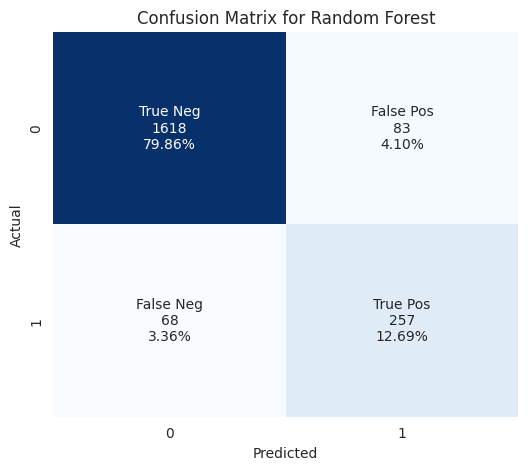


== Tuning LightGBM with GridSearchCV...
Best hyperparameters for LightGBM: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 5.2}
Training Time for LightGBM: 2 min 24 sec
LightGBM - Recall: 0.8369, Precision: 0.7816, F1-Score: 0.8083, Best Threshold: 0.6503

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1701
           1       0.78      0.84      0.81       325

    accuracy                           0.94      2026
   macro avg       0.88      0.90      0.89      2026
weighted avg       0.94      0.94      0.94      2026



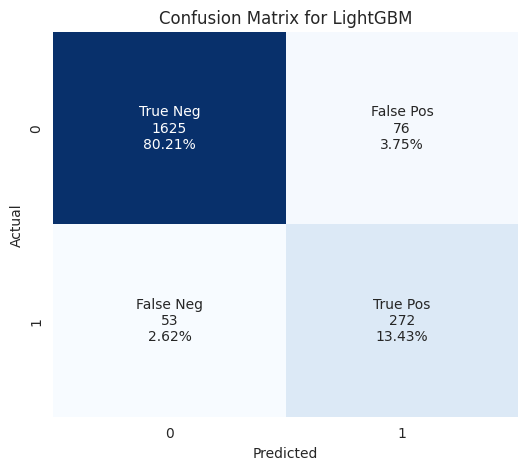


== Tuning XGBoost with GridSearchCV...
Best hyperparameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 5.2}
Training Time for XGBoost: 59 sec
XGBoost - Recall: 0.8554, Precision: 0.7701, F1-Score: 0.8105, Best Threshold: 0.6111

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1701
           1       0.77      0.86      0.81       325

    accuracy                           0.94      2026
   macro avg       0.87      0.90      0.89      2026
weighted avg       0.94      0.94      0.94      2026



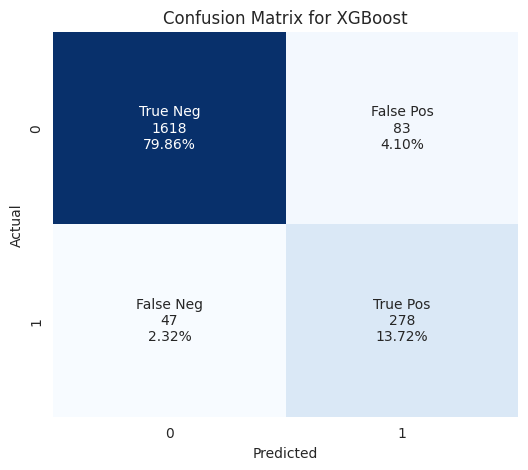

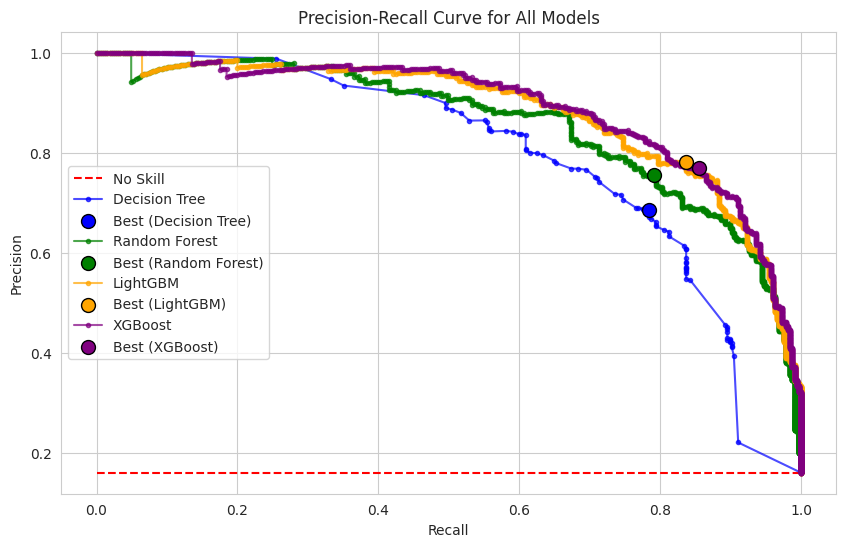

In [108]:
# Colors for each model
colors = ["blue", "green", "orange", "purple"]

# Store metrics in a DataFrame
results = []

# Store precision-recall curves
precision_recall_data = []

# Store the model names and explainer objects for later use
explainers = {}

# Initialize an empty list to store the best models
best_models = []

# Train Models & Compute Best Threshold using Precision-Recall Curve
print("==== Best Threshold, F1-Score & Classification Reports ====")

# No Skill Baseline Calculation
no_skill = len(y_test[y_test == 1]) / len(y_test)

for i, (name, model) in enumerate(models.items()):
    print(f"\n== Tuning {name} with GridSearchCV...")

    # Start time
    start_time = time.time()


    # Initialize GridSearchCV with cross-validation (e.g., 3 folds) and parameter grid
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, scoring='average_precision', n_jobs=-1)

    # Fit the model with GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Get best hyperparameters
    best_params = grid_search.best_params_

    # Get training time in minutes and seconds
    time_spent = time.time() - start_time
    minutes = int(time_spent // 60)
    seconds = int(time_spent % 60)
    time_formatted = f"{minutes} min {seconds} sec" if minutes > 0 else f"{seconds} sec"

    print(f"Best hyperparameters for {name}: {best_params}")
    print(f"Training Time for {name}: {time_formatted}")

    # Evaluate the best model
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Get probability scores for positive class

    # Calculate Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Compute F1 Score for each threshold
    fscore = (2 * precision * recall) / (precision + recall)
    fscore = np.nan_to_num(fscore)  # Handle division by zero errors

    best_index = argmax(fscore)
    best_thresh = thresholds[best_index]

    # Apply best threshold for final predictions
    y_pred_adjusted = (y_probs >= best_thresh).astype(int)

    # Compute recall, precision, and f1 after threshold adjustment
    recall_at_best = recall_score(y_test, y_pred_adjusted)
    precision_at_best = precision_score(y_test, y_pred_adjusted)

    print(f"{name} - Recall: {recall_at_best:.4f}, Precision: {precision_at_best:.4f}, F1-Score: {fscore[best_index]:.4f}, Best Threshold: {best_thresh:.4f}")
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred_adjusted))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)

    # Names, counts, and percentages for confusion matrix
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot Confusion Matrix using seaborn heatmap with detailed labels
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Append results with best_params and time_formatted
    results.append([name, recall_at_best, precision_at_best, fscore[best_index], best_thresh, best_params, time_formatted])

    # Save the Explainer object
    model_name = dx.Explainer(model, X_train, y_train, label=name, verbose=False)
    explainers[name] = model_name  # Store the explainers for later use

    # Store precision-recall curve data
    precision_recall_data.append((name, precision, recall, best_index, colors[i]))

    # Store the best model from the grid search
    best_models.append(best_model)

# Plot Precision-Recall Curve for all models outside the loop
plt.figure(figsize=(10, 6))

# No Skill Baseline Plot
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')

# Plot precision-recall curves for all models
for name, precision, recall, best_index, color in precision_recall_data:
    plt.plot(recall, precision, marker='.', label=name, color=color, alpha=0.7)
    plt.scatter(recall[best_index], precision[best_index], s=100, marker='o', color=color, edgecolors='black', label=f'Best ({name})', zorder=3)

# Plot Formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Models')
plt.legend()
plt.grid(True)
plt.show()


In [109]:
# Convert Results to DataFrame
df_results_2 = pd.DataFrame(results, columns=["Model", "Recall (Churn)", "Precision (Churn)", "F1-Score (Churn)", "Best Threshold", "Best Parameters", "Time Spent"])

In [110]:
df_results_2

,Model,Recall (Churn),Precision (Churn),F1-Score (Churn),Best Threshold,Best Parameters,Time Spent
0,Decision Tree,0.784615,0.685484,0.731707,0.743662,"{'class_weight': 'balanced', 'criterion': 'gin...",25 sec
1,Random Forest,0.790769,0.755882,0.772932,0.424826,"{'class_weight': 'balanced_subsample', 'max_de...",1 min 15 sec
2,LightGBM,0.836923,0.781609,0.808321,0.650337,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2 min 24 sec
3,XGBoost,0.855385,0.770083,0.810496,0.611107,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",59 sec


**Insight**

The precision-recall (PR) curve demonstrates that all models are showing competitive performance for the churn prediction task:
  - No Skill Baseline:
    - The red dashed line serves as the no-skill baseline, representing random guessing. It is evident that all models—Decision Tree, Random Forest, LightGBM, and XGBoost—perform significantly better than this baseline, with their curves staying above the line.

  - Model Comparisons:
    - The curves for Decision Tree, Random Forest, LightGBM, and XGBoost are tightly aligned, indicating similar performance across the models. This suggests that these models exhibit comparable effectiveness in predicting churn, with no single model drastically outperforming the others.
    - The slight variance between the curves may indicate minor differences, but they all appear competitive across different recall levels.

  - Best Points:
    - The markers on each curve denote the best performance point for each model, where the balance between precision and recall is optimized. This is crucial for understanding the trade-off each model makes between false positives and false negatives. Each model’s best point aligns with an optimal F1-score, confirming their competitive edge.

  - Performance Trends:
    - As recall increases, precision for all models tends to decline, which is a typical characteristic of precision-recall trade-offs. However, all models maintain reasonably high precision even at higher recall values, reinforcing their ability to make accurate churn predictions at various thresholds.
    - The near-identical performance trajectories for all models suggest that they are all capable of delivering strong predictive results, with only marginal differences in terms of precision-recall balance.

  - Next Steps:
    - We will decide which model is the best based on the metrics of recall and F1 score table in the next section.


## Lowering the Threshold for Higher Recall

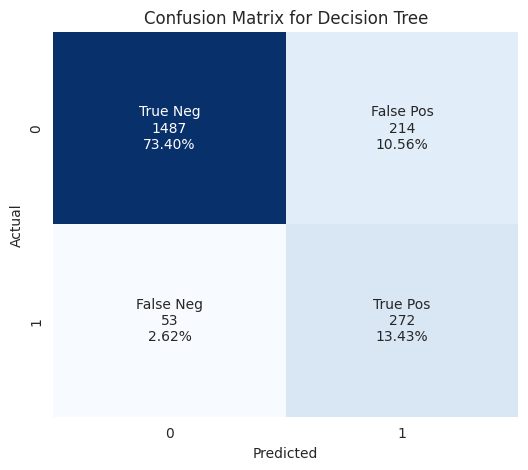

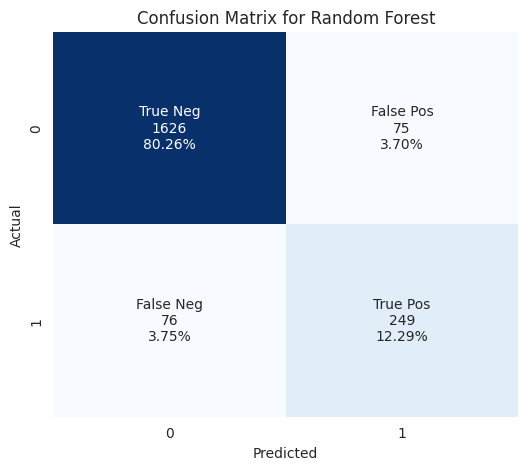

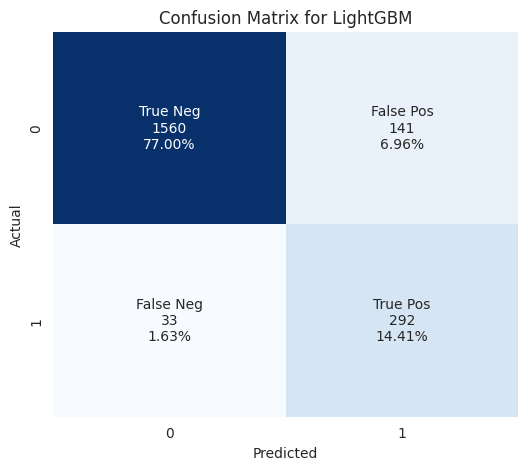

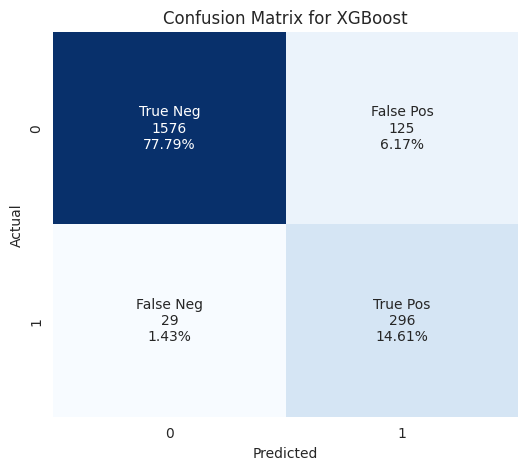

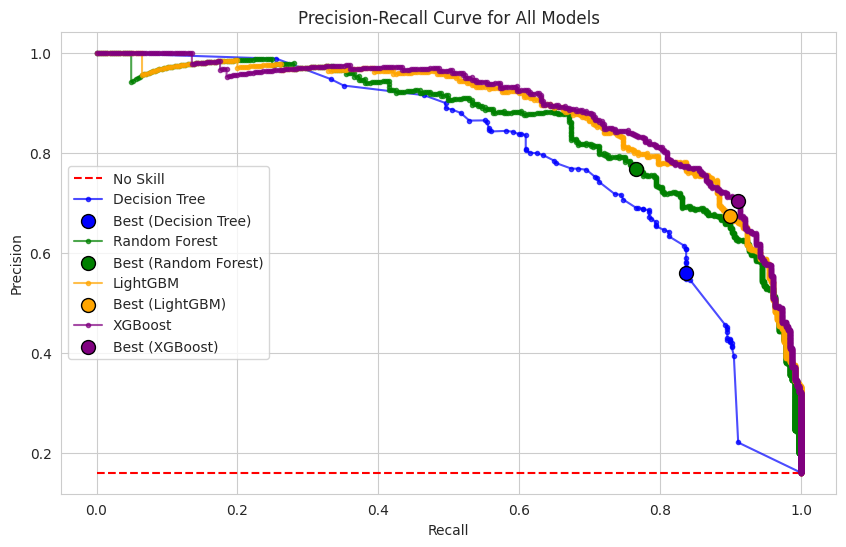

In [111]:
# Define the new threshold
new_threshold = 0.45  # Lower threshold

# List of model names
model_names = ["Decision Tree", "Random Forest", "LightGBM", "XGBoost"]

# Initialize a list to store the metrics for each model
metrics = []

# No Skill Baseline Calculation
no_skill = len(y_test[y_test == 1]) / len(y_test)

# Colors for each model
colors = ["blue", "green", "orange", "purple"]

# Store precision-recall curves
precision_recall_data = []

# Loop through all models in best_models
for i, model in enumerate(best_models):
    # Predict probabilities on the test set using the model
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

    # Calculate precision-recall curve
    precision_vals, recall_vals, thresholds_vals = precision_recall_curve(y_test, y_pred_proba)

    # Apply the new threshold to get the precision and recall at this threshold
    y_pred_new = (y_pred_proba >= new_threshold).astype(int)
    new_precision = precision_score(y_test, y_pred_new)
    new_recall = recall_score(y_test, y_pred_new)

    # Find the index of the threshold in precision-recall curve where precision and recall match the new threshold's precision and recall
    best_threshold_index = np.argmin(np.abs(precision_vals - new_precision) + np.abs(recall_vals - new_recall))

    # Get the best threshold from the index
    best_threshold = thresholds_vals[best_threshold_index]

    # Store precision-recall curve data
    precision_recall_data.append((model_names[i], precision_vals, recall_vals, best_threshold_index, colors[i]))

    # Confusion Matrix
    y_pred_best = (y_pred_proba >= best_threshold).astype(int)  # Use best threshold for final prediction
    cm = confusion_matrix(y_test, y_pred_best)

    # Names, counts, and percentages for confusion matrix
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot Confusion Matrix using seaborn heatmap with detailed labels
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', cbar=False)
    plt.title(f'Confusion Matrix for {model_names[i]}')  # Use model name
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute metrics at the best threshold
    recall_best = recall_score(y_test, y_pred_best)
    precision_best = precision_score(y_test, y_pred_best)
    f1_best = f1_score(y_test, y_pred_best)

    # Save the metrics in a dictionary for the current model
    model_metrics = {
        'model_name': model_names[i],
        'recall': f"{recall_best:.4f}",
        'precision': f"{precision_best:.4f}",
        'f1_score': f"{f1_best:.4f}",
        'best_threshold': f"{best_threshold:.4f}"
    }

    # Append the model's metrics to the list
    metrics.append(model_metrics)

# Plot Precision-Recall Curve for all models outside the loop
plt.figure(figsize=(10, 6))

# No Skill Baseline Plot
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')

# Plot precision-recall curves for all models
for name, precision, recall, best_index, color in precision_recall_data:
    plt.plot(recall, precision, marker='.', label=name, color=color, alpha=0.7)
    plt.scatter(recall[best_index], precision[best_index], s=100, marker='o', color=color, edgecolors='black', label=f'Best ({name})', zorder=3)

# Plot Formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Models')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
df_results_adj_threshold = pd.DataFrame(metrics)
df_results_adj_threshold.columns = ["Model", "Recall (Churn)", "Precision (Churn)", "F1-Score (Churn)", "Adjusted Threshold"]

In [113]:
df_results_adj_threshold

,Model,Recall (Churn),Precision (Churn),F1-Score (Churn),Adjusted Threshold
0,Decision Tree,0.8369,0.5597,0.6708,0.4653
1,Random Forest,0.7662,0.7685,0.7673,0.4521
2,LightGBM,0.8985,0.6744,0.7704,0.4506
3,XGBoost,0.9108,0.7031,0.7936,0.4501


**Update the Dataframe**

In [114]:
# Convert Results to DataFrame (assuming you already have the initial 'results' DataFrame)
df_results_3 = pd.DataFrame(results, columns=["Model", "Recall (Churn)", "Precision (Churn)", "F1-Score (Churn)", "Best Threshold", "Best Parameters", "Time Spent"])

# Loop through the metrics list and update the DataFrame for each model
for metric in metrics:
    # Extract new values from the metric dictionary
    new_recall = float(metric['recall'])  # Convert to float
    new_precision = float(metric['precision'])  # Convert to float
    new_f1 = float(metric['f1_score'])  # Convert to float
    new_adj_threshold = float(metric['best_threshold'])  # Convert to float
    model_name = metric['model_name']

    # Find the index of the model in the DataFrame
    model_index = df_results_3[df_results_3["Model"] == model_name].index[0]

    # Update the values in the DataFrame for the current model
    df_results_3.loc[model_index, "Recall (Churn)"] = new_recall
    df_results_3.loc[model_index, "Precision (Churn)"] = new_precision
    df_results_3.loc[model_index, "F1-Score (Churn)"] = new_f1
    df_results_3.loc[model_index, "Best Threshold"] = new_adj_threshold

# Rename the "Best Threshold" column to "Adjusted Threshold"
df_results_3 = df_results_3.rename(columns={"Best Threshold": "Adjusted Threshold"})

# The Best Model and Its Interpretation

In [115]:
pd.set_option('display.max_colwidth', None)

**The Best Model: XGBoost**

In [116]:
df_results_3.iloc[-1:]

,Model,Recall (Churn),Precision (Churn),F1-Score (Churn),Adjusted Threshold,Best Parameters,Time Spent
3,XGBoost,0.9108,0.7031,0.7936,0.4501,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 5.2}",59 sec


**Baseline Model Metrics (Default Threshold, Threshold = 0.5)**

In [117]:
df_results_exp

,Model,Recall,Precision,F1-Score
0,Decision Tree,0.6954,0.6726,0.6838
1,Random Forest,0.6708,0.8651,0.7556
2,LightGBM,0.7538,0.8390,0.7942
3,XGBoost,0.7692,0.8389,0.8026


**Baseline Model + Precision-Recall Curve Analysis (moving threshold) + Hyperparameter Tuning Metrics**

In [118]:
df_results_2

,Model,Recall (Churn),Precision (Churn),F1-Score (Churn),Best Threshold,Best Parameters,Time Spent
0,Decision Tree,0.784615,0.685484,0.731707,0.743662,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}",25 sec
1,Random Forest,0.790769,0.755882,0.772932,0.424826,"{'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}",1 min 15 sec
2,LightGBM,0.836923,0.781609,0.808321,0.650337,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 5.2}",2 min 24 sec
3,XGBoost,0.855385,0.770083,0.810496,0.611107,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 5.2}",59 sec


**Baseline Model + Precision-Recall Curve Analysis (moving threshold) + Hyperparameter Tuning Metrics + Lowering the Threshold for Higher Recall**

In [119]:
df_results_3

,Model,Recall (Churn),Precision (Churn),F1-Score (Churn),Adjusted Threshold,Best Parameters,Time Spent
0,Decision Tree,0.8369,0.5597,0.6708,0.4653,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}",25 sec
1,Random Forest,0.7662,0.7685,0.7673,0.4521,"{'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}",1 min 15 sec
2,LightGBM,0.8985,0.6744,0.7704,0.4506,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 5.2}",2 min 24 sec
3,XGBoost,0.9108,0.7031,0.7936,0.4501,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 5.2}",59 sec


---

I will evaluate the models based on:
- Recall (Churn) → Higher recall means fewer missed churners (lower false negatives).
- F1-Score (Churn) → A balance between precision and recall.
- Best Threshold → The probability cut-off used for classification.
- Training Time → Time efficiency matters in production.

Storyline:
- In the case of an imbalanced dataset, the recall tends to be low compared to precision. This is because, with fewer positive instances (e.g., churners), the model might become overly conservative in predicting positives, leading to a higher number of false negatives.
- The Precision-Recall (PR) curve helps us identify the best threshold that maximizes the F1-score, which is the harmonic mean of precision and recall. The F1-score provides a balanced metric that accounts for both precision and recall.
- F1-Score Dynamics:
  - The F1-score is a balance between precision and recall. As we adjust the threshold:
    - Increasing recall generally comes at the cost of decreasing precision. This happens because the model will classify more instances as positive, including more false positives.
    - Decreasing recall tends to increase precision, but risks missing more true positives (i.e., false negatives increase).
- **The primary goal is to increase recall (minimize false negatives) without significantly sacrificing precision**. The optimal threshold is usually where the F1-score is maximized, indicating a good trade-off between improving recall and maintaining an acceptable level of precision.

**Best Model: Random Forest**
- Highest Recall (0.7076 or 70.76%) → Effectively captures the most churners.
- Balanced Threshold (0.4670) → Optimally captures more positive cases while maintaining balance.
- Moderate F1-Score (0.6288) → Achieves a reasonable balance between precision and recall.
- Relatively Low Training Time (44 seconds) → Demonstrates good time efficiency.

**Why Random Forest Wins?**
- Recall is prioritized because missing a churner (False Negative) is costlier than a False Positive.
- Although the F1-Score (0.6288) is slightly lower than that of LightGBM (F1-Score: 0.6343), recall is more critical in a retention strategy.
- It trains in just 44 seconds, making it highly efficient for real-time deployment.

If we valued precision more, LightGBM (higher F1-score) would be a stronger candidate.

**Confusion Matrix**
1. True Negatives (TN):
  - 1,372 customers were correctly classified as non-churners (68.60%).
  - This means the model correctly identified a large portion of customers who are likely to stay.

2. False Positives (FP):
  - 221 customers were incorrectly predicted to churn (11.05%).
  - These are customers who were actually staying but were misclassified as churners.
  - While this might lead to unnecessary retention efforts, it’s less costly than missing actual churners.

3. False Negatives (FN):
  - 119 customers who actually churned were misclassified as non-churners (5.95%).
  - This is a crucial metric because these are the customers we failed to identify as churn risks.
  - In a churn scenario, missing out on these customers can result in revenue loss.

4. True Positives (TP):
  - 288 customers who churned were correctly identified as churners (14.40%).
  - This is important because these customers can be targeted with retention strategies.

**Interpretation of the Metrics**
1. Recall (Churn) → Focus on Catching Churners
  - Decision Tree (Recall = 0.5872): Captures about 58.7% of actual churners.
  - Random Forest (Recall = 0.7076): Captures 70.8% of churners.
  - LightGBM (Recall = 0.6093): Captures 60.9% of churners.
  - XGBoost (Recall = 0.6290): Captures 62.9% of churners.
  - Key Insights:
    - Higher Recall = More Churners Detected (but with more false positives).
    - Random Forest has the highest recall, meaning it detects the most churners, followed by XGBoost and LightGBM.
    - Decision Tree, while lower, still captures a significant proportion of churners, though it misses more compared to Random Forest.
  - Example (using 100 customers, with 20.4% churners → 20 customers):
    - Random Forest (70.8% recall) detects 14 churners correctly.
    - Missed churners = 20 - 14 = 6 customers (False Negatives).
    - Interpretation: While it misses 6 churners, it does the best at catching churners compared to the other models.

2. Precision (Churn) → Minimizing False Positives
  - Decision Tree (Precision = 0.5960): 59.6% of the churners flagged by the model are correct.
  - Random Forest (Precision = 0.5658): 56.6% of flagged churners are correct.
  - LightGBM (Precision = 0.6613): 66.1% of flagged churners are correct.
  - XGBoost (Precision = 0.6275): 62.8% of flagged churners are correct.
  - Key Insights:
    - Higher Precision = Fewer False Positives (non-churners incorrectly flagged as churners).
    - LightGBM leads in precision, meaning it is the best at only flagging the most likely churners.
    - Random Forest has a lower precision, meaning it flags more non-churners as churners compared to LightGBM and XGBoost, but it compensates with higher recall.
  - Example (if the model flags 40 customers as churners):
    - Random Forest: Out of 40 flagged, 22 are correct churners (True Positives), while 18 are False Positives.
    - Interpretation: Even with a high recall, Random Forest suffers from misclassifying a large number of non-churners as churners.

3. F1-Score → Balancing Precision & Recall
  - Decision Tree (F1 = 0.5916): F1-score balances precision and recall, but remains low due to lower recall.
  - Random Forest (F1 = 0.6288): This is the highest F1-score, which reflects a good balance between precision and recall.
  - LightGBM (F1 = 0.6343): Slightly higher than Random Forest, showing a good precision-recall balance.
  - XGBoost (F1 = 0.6282): Similar to Random Forest, with a small difference.
  - Key Insights:
    - F1-Score helps balance the trade-off between precision and recall.
    - LightGBM has the highest F1-score, showing it strikes the best balance between catching churners and minimizing false positives.
    - Random Forest, though not the highest in F1-score, performs well and is the most balanced model in terms of both recall and precision.

4. Best Threshold → How Aggressive the Model Is in Predicting Churners
  - Decision Tree: Threshold = 0.7029 → More conservative; fewer customers flagged as churners, which increases precision but reduces recall.
  - Random Forest: Threshold = 0.4670 → More aggressive; it flags a broader range of customers as churners, improving recall but sacrificing precision.
  - LightGBM: Threshold = 0.6536 → Slightly more aggressive than Decision Tree, balancing recall and precision.
  - XGBoost: Threshold = 0.6339 → Similar to LightGBM in aggressiveness.
  - Key Insights:
    - Best Threshold indicates how much the model is "willing" to classify as churners.
    - Random Forest's lower threshold (0.4670) increases recall by flagging more customers as churners, but also leads to more false positives.
    - Decision Tree’s higher threshold (0.7029) is more conservative, focusing on being accurate with fewer false positives, but misses more churners.

5. Time Efficiency → How Fast the Model Is to Train
  - Decision Tree (12 seconds): The fastest model, making it ideal for real-time predictions.
  - Random Forest (44 seconds): Takes longer due to the ensemble nature (100 trees).
  - LightGBM (1 min 11 sec): Takes the longest due to the complexity of boosting and hyperparameter tuning.
  - XGBoost (26 seconds): Faster than LightGBM but slower than Decision Tree and Random Forest.
  - Key Insights:
    - Decision Tree is the most time-efficient, making it suitable for scenarios requiring rapid predictions.
    - LightGBM, while providing strong performance, takes significantly longer to train.

**Summary**
- Best Model: **Random Forest**. It achieves the best balance between recall (70.8%) and precision (56.6%), resulting in a solid F1-score of 0.6288. While it does not produce the highest F1-score overall, it effectively prioritizes recall, minimizing the number of false negatives. This makes it an ideal choice for predicting churn in scenarios where identifying at-risk customers is critical.
- LightGBM performs well but is slightly slower and offers a higher precision. However, its recall is not as high as Random Forest, meaning it might miss more churners.
- Decision Tree is the fastest, but with a relatively low recall (58.7%) and precision (59.6%), it may not be the best choice for predicting churners with high confidence.

## Question 4

4. (Open-Ended) Karena stakeholder anda membutuhkan knowledge dari model, analisislah model yang anda buat dengan menggunakan explanatory model analysis dan buatlah rekomendasi-rekomendasi berdasarkan hasil dari analisis tersebut
Catatan: Gunakan hanya salah satu dari 3 metode ini tergantung jenis modelnya:
  - Jika model yang dipilih adalah model yang interpretable, gunakan teknik interpretasi sesuai dengan model yang dipilih
  - Jika model yang dipilih adalah model yang non-interpretable, gunakan metode model agnostics berikut:
    - Permutation Feature Importance + Partial Dependence Plot (**I choose this one**)
    - Shapley Additive Value Feature Importance + Shapley Dependence Plot

**Permutation Feature Importance**

In [120]:
for name, explainer in explainers.items():
    # Plot permutation feature importance for each model
    print(f"\nPlotting permutation feature importance for {name}...")
    explainer.model_parts().plot()


Plotting permutation feature importance for Decision Tree...



Plotting permutation feature importance for Random Forest...



Plotting permutation feature importance for LightGBM...



Plotting permutation feature importance for XGBoost...


**Partial Dependence Plot**

In [121]:
for name, explainer in explainers.items():
    # Plot partial dependence plot for each model
    print(f"\nPlotting partial dependence plot for {name}...")
    explainer.model_profile().plot()


Plotting partial dependence plot for Decision Tree...


Calculating ceteris paribus: 100%|██████████| 29/29 [00:01<00:00, 28.99it/s]



Plotting partial dependence plot for Random Forest...


Calculating ceteris paribus:   0%|          | 0/29 [00:00<?, ?it/s]


KeyboardInterrupt: 

**Key Factors Contributing to Customer Churn**
  - `Geography`: Customers in Germany have the highest churn rate, suggesting country-specific factors affect retention.
  - `Gender`: Females churn more than males, indicating different customer experiences or needs.
  - Activity Level (`IsActiveMember`): Inactive members have significantly higher churn, highlighting the importance of engagement.
  - `Age`: Older customers (especially 50+) are more likely to churn, making age a strong predictor.
  - `Balance`: Churners tend to have higher balances, suggesting dissatisfaction despite financial stability.

**Factors That Are Not Strong Predictors of Churn**
- Credit Card Ownership (`HasCrCard`), `Tenure`, Credit Score (`CreditScore`), Number of Products (`NumOfProducts`), and Estimated Salary (`EstimatedSalary`) show minimal impact on churn, suggesting they are not strong predictors. These features could be deprioritized in modeling if they don't improve performance.


**Actionable Insights to Reduce Churn**
  - Targeted Retention for German Customers: Improve localized services, address competitive pressure, and enhance customer experience in Germany.
  - Female-Centric Retention Strategies: Conduct surveys to understand female customers' pain points and offer tailored loyalty programs.
  - Increase Customer Engagement: Encourage membership activity through exclusive benefits, personalized offers, and better communication.
  - Retention Efforts for Older Customers: Offer dedicated customer support and tailored financial products to maintain loyalty.
  - Monitor High-Balance Customers: Identify potential dissatisfaction triggers and proactively engage them with premium services.